### Overview and Motivation

The goal of this notebook is to provide a network architecture capable of recovering a unitary amplitude (in particular its phase $\phi(z)$) corresponding to a given input modulus $B(z)$ . Unitarity is enforced by solving the unitary equation 

$$B (z) \sin \phi (z) = \frac{1}{4 \pi} \int_{- 1}^1 d z_1  \int_0^{2 \pi} d
   \phi_1 B (z_1) B (z_2) e^{i \phi (z_1) - i \phi (z_2)} $$
   
   where we use $z_2 = zz_1 + (1 - z^2)^{1 / 2}  (1 - z_1^2)^{1 / 2} \cos \phi_1$. Here $z$ is $\cos \theta$, with $\theta$ the scattering angle
   
To tackle this problem we will represent $\phi(z)$ by a neural network and try and solve the integral equation, by characterizing it as a term in the loss function $\mathcal{L}$.

In our setup also includes a repulsive loss term in the loss function that enables the recovery of distinct phases when those exist

### Implementation

##### Start with the imports and general setup

Import the necessary modules and set the device

In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, MultiplicativeLR
from torch import Generator
import math
from collections import OrderedDict
import numpy as np
from itertools import chain
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc

Check for available GPU or MPS and set the device for PyTorch tensors.

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

General plotting parameters and routines

##### Define the neural networks

Provide the option to use a custom Sigmoid final layer (could also be learned)

In [19]:
def cust_sigmoidal(z, end_low=-math.pi, end_high=math.pi, slope_fact=5):
    range_diff = (end_high-end_low)/2
    range_tot = (end_high+end_low)/2
    
    return range_diff* torch.sigmoid(slope_fact*(z-range_tot)) +range_tot

class Custom_Sigmoid(nn.Module):
    def __init__(self, slope_sigmoid=10):
        super(Custom_Sigmoid, self).__init__()
        self.slope_sigmoid = slope_sigmoid
        #self.slope_sigmoid = slope_sigmoid * torch.nn.Parameter(torch.ones(1)) # If we want to learn the slope
    
    def forward(self, z):
        return cust_sigmoidal(z, slope_fact=self.slope_sigmoid)

Define the Neural Network Ansatz for the phase

In [20]:
class PhiNet(nn.Module):
    def __init__(self, ffnlayers, activation, device='cpu', final_layer='Sigmoid'):
        """
        Initialize the network with the number of FC layers, the activation function, and the device to use
        """
        super(PhiNet, self).__init__()
        
        self.device = device
        
        if activation=='ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Activation function '{}' not supported. Supported activation functions are 'ReLU' and 'Tanh'".format(activation))

        
        if final_layer=='Sigmoid':
            self.final_layer = nn.Sigmoid()
            self.final_l = 'Sigmoid'
        elif final_layer == 'Tanh':
            self.final_layer = nn.Tanh()
            self.final_l = 'Tanh'
        elif final_layer == 'Custom_Sigmoid':
            self.final_layer = Custom_Sigmoid()
            self.final_l = 'Custom_Sigmoid'
        elif final_layer == 'Identity':
            self.final_layer = nn.Identity()
            self.final_l = 'Identity'
        else:
            raise ValueError("Final layer '{}' not supported. Supported final layers are 'Sigmoid', 'Tanh' and 'Identity'".format(final_layer))

        
        # Create a list of layers from the parameters given. Add the appropriate activation function
        self.layer_sizes = ffnlayers
        layer_list = []
        
        for i, layer_size in enumerate(self.layer_sizes):
            if i == 0:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(1, layer_size)))
                layer_list.append(('activation_%d' % (i+1), self.activation))
            else:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.layer_sizes[i-1], layer_size)))
                layer_list.append(('activation_%d' %(i+1), self.activation))
        
        layer_list.append(('layer_%d' % (len(self.layer_sizes)+1), nn.Linear(self.layer_sizes[-1], 1)))
        
        # The last layer is sigmoid to constrain outputs between 0 and 1 or tanh for [-1,1]
        layer_list.append(('final_layer', self.final_layer))
            
        
        self.model = nn.Sequential(OrderedDict(layer_list))
    
    
    def forward(self, x):
        """
        Network forward pass where the outputs for the phase are in [-pi/2, pi/2] or [-pi, pi]
        """
        x = self.model(x)
        if self.final_l == 'Identity' or self.final_l == 'Custom_Sigmoid':
            return x
        if self.final_l == 'Sigmoid':
            return 2*math.pi*x - math.pi
        elif self.final_l == 'Tanh':
            return math.pi*x
        else:
            raise ValueError('No good activation function')

Define a structure for the input modulus

In [30]:
class ModuleNetManual(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self, scan_param=None, func_class='linear'):
        super(ModuleNetManual, self).__init__()
        self.scan_param = scan_param
        self.func_class = func_class
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function. Can iterate on the overall scale if we want to
        """
        
        denom = self.scan_param if self.scan_param is not None else 1
        if self.func_class == 'linear':
            return (x + 4)/denom
        if self.func_class == 'absolute_linear':
            return torch.abs((3*x + 1)/denom)
        elif self.func_class == 'quadratic':
            return (torch.pow(x,2) + 1)/denom
            #return (torch.pow(x,2)*5*np.sqrt(3/2) + np.sqrt(3/2))/denom
        elif self.func_class == 'cubic':
            return (-torch.pow(x,3) + torch.pow(x,2) + x + 1)/denom
        elif self.func_class == 'quadratic_path':
            return (torch.pow(x,2)/2 + denom)
        else:
            raise ValueError('Did not recognize / implement the function type {}'.format(self.func_class))


##### Main Solver class

Solver defines the loss function from the unitarity equation by discretization of the integral
Also implements the repulsive loss
The main training loop supports a learning rate Scheduler and both Adam and LBFGS

In [184]:
class PhaseNetSolver():
    """
    Main class for crafting the simulation
    """
    def __init__(self, params_simu, phi_net, mod_net, optimizer, random_generator, scheduler, device='cpu'):
        """
        Initialize the simulation with the networks, the loss function and the optimizer
        """
        
        self.epochs = params_simu['epochs_num']
        self.batch_size = params_simu['batch_size']
        self.eval_points_num = params_simu['integral_points']
        self.scaled_loss = params_simu['scaled_loss']
        self.method_int = params_simu['method_int']
        self.p_value = params_simu['p_value']
        self.lambda_repulsive = params_simu['lambda_repulsive']
        self.repulsive_epochs = params_simu['repulsive_epochs']
        self.repulsive_type = params_simu['repulsive_type']
        self.loss_func = params_simu['loss']
        
        if isinstance(phi_net, list):
            self.multi_nets = [net.to(device) for net in phi_net]
            self.phi_net = None
            self.multiple_nets = True
        else:
            self.multi_nets = None
            self.phi_net = phi_net.to(device)
            self.multiple_nets = False
        self.mod_net = mod_net.to(device)
        self.device = device
        self.rand_gen = random_generator
        
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.log_loss = False
        self.log_loss_values = []
    
    def z2(self, z, z1, phi):
        """
        Compute the z2 parameter (formula in motivation)
        Place the batch size on first dim, z1 on the second and phi on the third
        """
        term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
        term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
        return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)
    
    def integral_approximator(self, z, method='trapz'):
        """
        Approximate the value of the RHS of the integral equation.
        Compute the grids of z1 and phi points for given z values and integrate over the grids
        """
        
        # Linear partition of the space
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)
        
        grid_points = self.mod_net(z1_points).view(1,-1,1)*self.mod_net(self.z2(z, z1_points, phi_points))*torch.cos(self.phi_net(z1_points.view(1,-1,1)) - self.phi_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1)).squeeze())
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
        return integral
    
    def loss_function(self, zsamples):
        """
        Compute a loss based on the average residuals for the integral equation
        """
        
        # For each value of z we estimate the integral equation
        target = torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze()) if self.scaled_loss else self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        model_input = self.integral_approximator(zsamples, method=self.method_int)
        
        # If scaled then all targets should be sin phase
        if self.scaled_loss:
             model_input = model_input / (self.mod_net(zsamples))
                
        # We have different choices of losses. Huber is more stable to outliers.
        if self.loss_func =='Huber':
            loss_out = F.huber_loss(model_input, target, delta=0.1)
        elif self.loss_func == 'MSE':
            loss_out = F.mse_loss(model_input, target)
        else:
            raise NotImplemented
        
        return loss_out
    
    def multi_loss_function(self, zsamples):
        
        if not self.multiple_nets:
            raise NotImplemented
        
        total_loss = 0
        for i, net in enumerate(self.multi_nets):
            self.phi_net = net
            individual_loss = self.loss_function(zsamples)
            total_loss = total_loss + individual_loss
        
        return total_loss
   
    
    def dual_loss_ambiguity(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        
        net1_val = self.multi_nets[0](zsamples.view(-1,1)).squeeze()
        net2_val = self.multi_nets[1](zsamples.view(-1,1)).squeeze()
        
        target = torch.stack((torch.cos(net1_val), torch.sin(net1_val)))
        model_input1 = torch.stack((torch.cos(net2_val), torch.sin(net2_val)))
        model_input2 = torch.stack((-torch.cos(net2_val), torch.sin(net2_val)))
        
        if self.repulsive_type == 'sharp':
            # Sharp repulsive loss
            loss_out1 = torch.pow(F.mse_loss(model_input1, target), -self.p_value)
            loss_out2 = torch.pow(F.mse_loss(model_input2, target), -self.p_value)

        elif self.repulsive_type == 'decay':
            # Repulsive loss with decay
            loss_out1 = 1-torch.tanh(self.p_value * F.mse_loss(model_input1, target))
            loss_out2 = 1-torch.tanh(self.p_value * F.mse_loss(model_input2, target))
        else:
            raise ValueError('Correct type of repulsion not specified')
        
        return loss_out1 + loss_out2
    
    def complete_loss(self, zsamples, dual_active):
        
        if not self.multiple_nets:
            return self.loss_function(zsamples)
        else:
            if len(self.multi_nets)!=2:
                raise NotImplemented
            if dual_active:
                repulsive_loss = self.dual_loss_ambiguity(zsamples)
            else: 
                repulsive_loss = 0.0
            
            unitarity_loss = self.multi_loss_function(zsamples)
            
            if repulsive_loss * 10 > unitarity_loss and self.lambda_repulsive>0.0:
                return unitarity_loss + self.lambda_repulsive * repulsive_loss
            else:
                return unitarity_loss
    
    def point_loss(self, zsamples):
        """
        If we want to know the residuals at each given z point. This is useful for evaluation purposes
        """
        target = torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze()) if self.scaled_loss else self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        model_input = self.integral_approximator(zsamples)
        
        if self.scaled_loss:
            model_input = model_input / (self.mod_net(zsamples))
        return torch.square(model_input - target)
        
    def train(self):
        """
        Main training loop. 
        Each epoch is a single optimization step over a unique batch.
        A batch is composed of a number of randomly selected z points between -1 and 1
        """
        
        p_value_init = self.p_value
        tq_iterator = tqdm(range(self.epochs), unit='epoch', leave=False)
        
        for epoch_num in tq_iterator:
            
            if self.repulsive_type is None:
                dual_active = False
            elif self.repulsive_type == 'sharp':
                dual_active = False if self.repulsive_epochs is None or epoch_num < self.repulsive_epochs[0] or epoch_num > self.repulsive_epochs[1] else True
            elif self.repulsive_type == 'decay':
                dual_active = True
                self.p_value = repulsive_decay_func(p_value_init, epoch_num, self.repulsive_epochs)
            
            # Set the network in train mode
            if self.multiple_nets:
                for net in self.multi_nets:
                    net.train()
            else:
                self.phi_net.train()
            
            if self.device is not torch.device('cuda'):
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device='cpu').to(self.device)*2 - 1
            else:
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device=self.device)*2 - 1
            
        
            if type(self.optimizer).__name__ == 'LBFGS':
                
                loss = self.complete_loss(zpoints, dual_active)
                
                def closure():
                    if torch.is_grad_enabled():
                        self.optimizer.zero_grad()
                    loss_comp = self.complete_loss(zpoints, dual_active)
                    if loss_comp.requires_grad:
                        loss_comp.backward()
                    return loss_comp

                self.optimizer.step(closure)
                   
            else:
                # Zero the grads, get the loss and backpropagate
                self.optimizer.zero_grad()
                loss = self.complete_loss(zpoints, dual_active)               
                loss.backward()
                self.optimizer.step()
                
                if self.log_loss:
                    self.log_loss_values.append(loss)
                
            if self.scheduler is not None:
                self.scheduler.step()
            
            tq_iterator.set_description('Train Epoch: {} ; tLoss: {:.6f}'.format(epoch_num,loss.item()))


Functions required for the Learning rate scheduler and the repulsive loss

In [179]:
def scheduler_rate_exp(step, gamma, max_ep):
    """
    For the Exponential Learning Rate scheduler where we decay only after the repulsive loss
    """
    if step < 0.3 * min(5000, max_ep):
        return 1
    else:
        return gamma
    

def repulsive_decay_func(p_value_init, epoch_num, repulsive_epochs, overall_scale=16):
    """
    Construct a profile function for the increase in the temperature parameter used
    in the repulsive loss
    """
    
    # Construct a hyperbolic tanh function with a maximum slope at the middle of the repulsive interval
    # The hyperbolic function reaches 0.99 at the end of the repulsive interval
    a = (repulsive_epochs[0] + repulsive_epochs[1])/(2*math.atanh((100-99*overall_scale)/(100-101*overall_scale)))
    b = (repulsive_epochs[1] - repulsive_epochs[0])/(2*a)
    
    delta1 = p_value_init *(101*overall_scale - 100) /200
    delta2 = p_value_init *(99*overall_scale + 100) /200
    
    return delta1*np.tanh(-b+epoch_num/a) + delta2

##### Define the training and evaluations runs

In [180]:
def train_run(parameters, device, module_net=None, phi_net=None, seed_num=42, optim_name='Adam', log_loss=False):
    """
    Function to call for launching the training run
    """
    # Fix for the generator : For reproducibility between cpu and MPS
    random_gen_cpu = Generator(device='cpu')
    random_gen_cpu.manual_seed(seed_num)
    torch.manual_seed(seed_num)   
    torch.cuda.manual_seed(seed_num)
    
    num_phi_nets = parameters['num_nets']
    
    # Define and register the networks
    if num_phi_nets>1:
        phinn = [PhiNet(parameters['layer_list'], parameters['activation'], device=device, final_layer=parameters['final_layer']) for i in range(num_phi_nets)]
    else:
        if phi_net is None:
            phinn = PhiNet(parameters['layer_list'], parameters['activation'], device=device, final_layer=parameters['final_layer'])
        else:
            phinn = phi_net

    if module_net is None:
        modnn = ModuleNetManual(scan_param=parameters['scan_param'], func_class=parameters['func_class'])
    else:
        modnn = module_net

        
    # Define and register the optimizer and scheduler
    if optim_name == 'Adam':
        if num_phi_nets>1:
            optimizer = torch.optim.Adam(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
        else:
            optimizer = torch.optim.Adam(phinn.parameters(), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
    elif optim_name == 'LBFGS':
        if num_phi_nets>1:
            optimizer = torch.optim.LBFGS(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], max_iter=50,tolerance_grad=1e-20)
        else:
            optimizer = torch.optim.LBFGS(phinn.parameters(), lr=parameters['learning_rate'], max_iter=50,tolerance_grad=1e-20)

    
    if parameters['lr_scheduler']:
        lr_scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate_exp(step, 0.999, parameters['epochs_num']))
    else:
        lr_scheduler = None
    
    # Create the simulation, train it and return the trained result
    netsolver = PhaseNetSolver(parameters, phinn, modnn, optimizer, random_gen_cpu, lr_scheduler, device=device)
    if log_loss:
        netsolver.log_loss = True
    netsolver.train()

    return netsolver

In [181]:
def eval_run(trained_solver, params, device, steps_eval=100, num=None):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    str_add = '_' + str(num) if num is not None else ''
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        results = trained_solver.phi_net(zpointstest.view(-1,1))
        phires = results.squeeze().cpu().numpy()
        sinphires = torch.sin(results).squeeze().cpu().numpy()
        
        # Also log the final loss values. Including the loss at individual z values
        trained_solver.scaled_loss = True
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        eval_point_loss_scaled = trained_solver.point_loss(zpointstest)
        
        trained_solver.scaled_loss = False
        eval_loss_base = trained_solver.loss_function(zpointstest)
        eval_point_loss_non_scaled = trained_solver.point_loss(zpointstest)
    
    return zpointstest, phires, sinphires, eval_point_loss_scaled, eval_point_loss_non_scaled

In [35]:
def sin_mu_integral(params, device, trained_solver, zpoints):
    """
    Helper function to compute the sin(\mu) variable defined in the motivation.
    This compute the relevant integral involving the differential cross section
    """
    z1_points = torch.linspace(-1,1,steps=params['integral_points'], device=device)
    phi_points = torch.linspace(0, 2*math.pi, steps=params['integral_points'], device=device)
    dx_z1 = 2/(params['integral_points']-1)
    dx_phi = 2*math.pi/(params['integral_points']-1)
        
    grid_points = trained_solver.mod_net(z1_points).view(1,-1,1)*trained_solver.mod_net(trained_solver.z2(zpoints, z1_points, phi_points))
        
    integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
    return integral/trained_solver.mod_net(zpoints)
   

##### Define the plotting routines

In [36]:
def plot_phase(zpoints, phipoints):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.xlim([-1,1])
    plt.show()
    plt.close(fig)
    
def plot_phases(zpoints, phipoints_list):

    fig = plt.figure(figsize=(14, 10))
    
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.legend(['Network {}'.format(i+1) for i in range(len(phipoints_list))])
    plt.xlim([-1,1])
    plt.show()
    plt.close(fig)
    
    
def plot_point_loss(zpoints, point_loss_data_s, point_loss_data_no_s):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(), np.log10(point_loss_data_s.cpu()), 'b-', linewidth = 2)  
    plt.plot(zpoints.cpu(), np.log10(point_loss_data_no_s.cpu()), 'g-', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['Normalized loss at each point', 'Base loss'])
    plt.show()
    plt.close(fig)
    

def plot_sin_mu(zpoints, integralpoints):

    sinmu = max(integralpoints.cpu())

    fig2 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.xlim([-1,1])
    plt.legend(['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    
def plot_summary(zpoints, phipoints, sinphipoints, integralpoints):
    
    sinmu = max(integralpoints.cpu())
    
    fig3 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.plot(zpoints.cpu(),sinphipoints, 'b--', linewidth = 2)       
    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.xlim([-1,1])
    plt.legend(['$\phi(z)$', '$\sin \phi(z)$','$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    plt.close(fig3)

### Single phase recovery

#### Simple Warm-Up Examples

Recover the phase for a single modulus $B(z)$ used as input which has $\sin \mu < 1$

##### Linear Modulus

In [37]:
params = {'batch_size': 64,
         'epochs_num': 5000,
         'learning_rate': 0.003,
         'repulsive_epochs': None,
         'repulsive_type' : None,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'func_class': 'linear',
         'loss': 'MSE',
         'scaled_loss': True,
         'scan_param': 10.0,
         'num_nets' : 1,
         'p_value': 2,
         'lambda_repulsive': 0.0}

In [38]:
netsolver = train_run(params, device, seed_num=10, optim_name='Adam')

  0%|          | 0/5000 [00:00<?, ?epoch/s]

Evaluation and plots

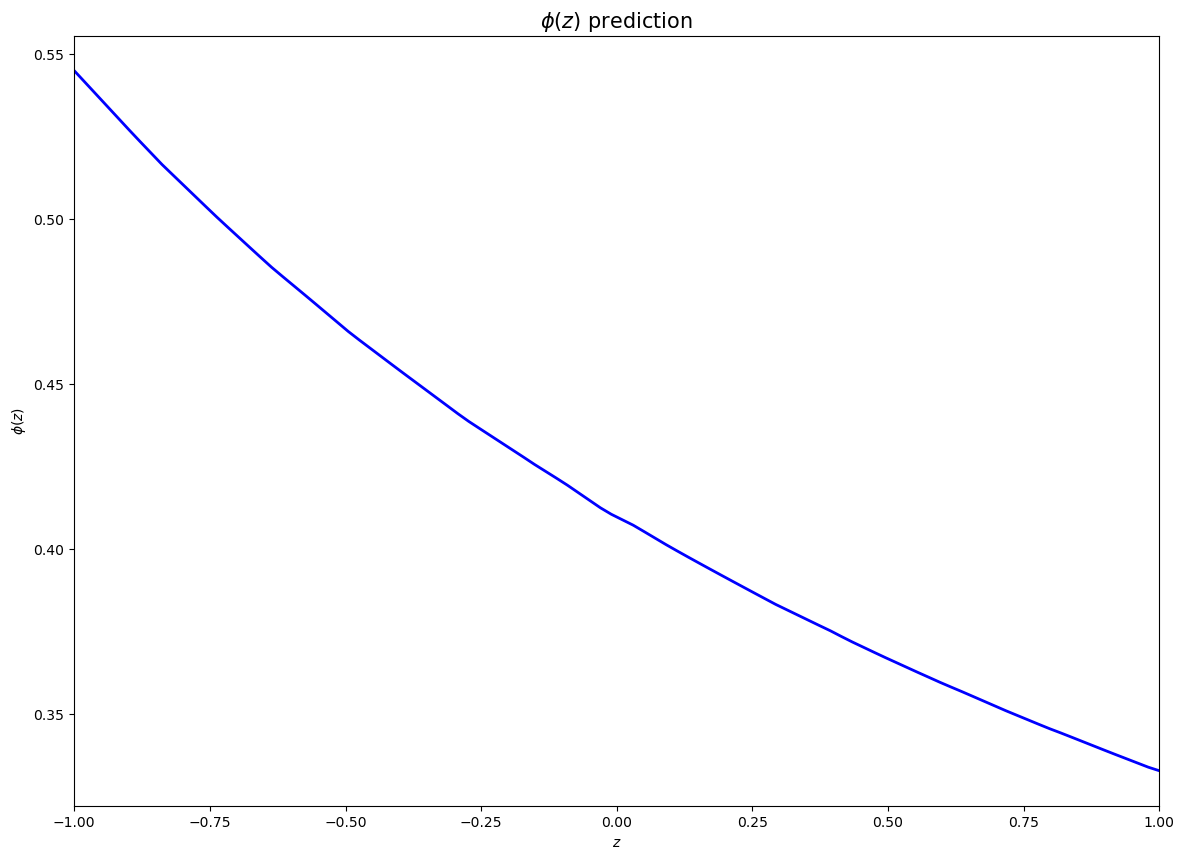

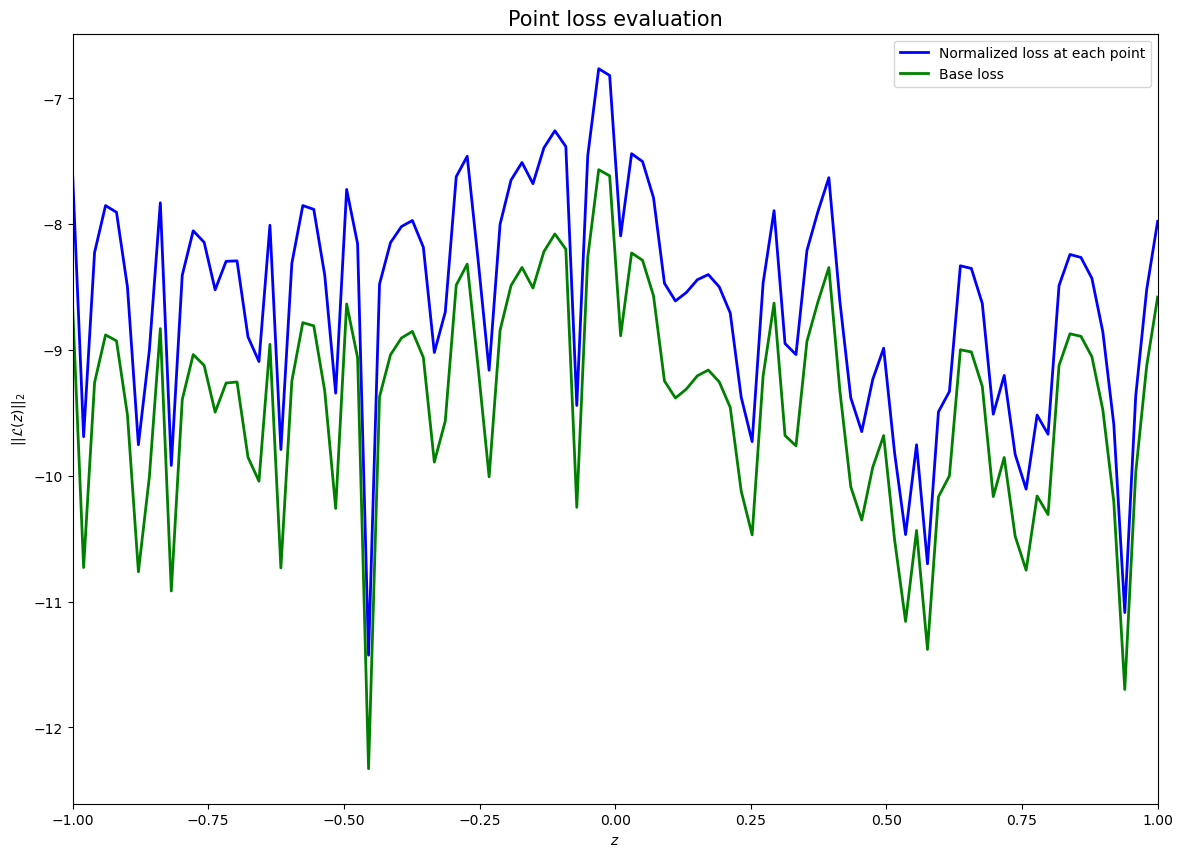

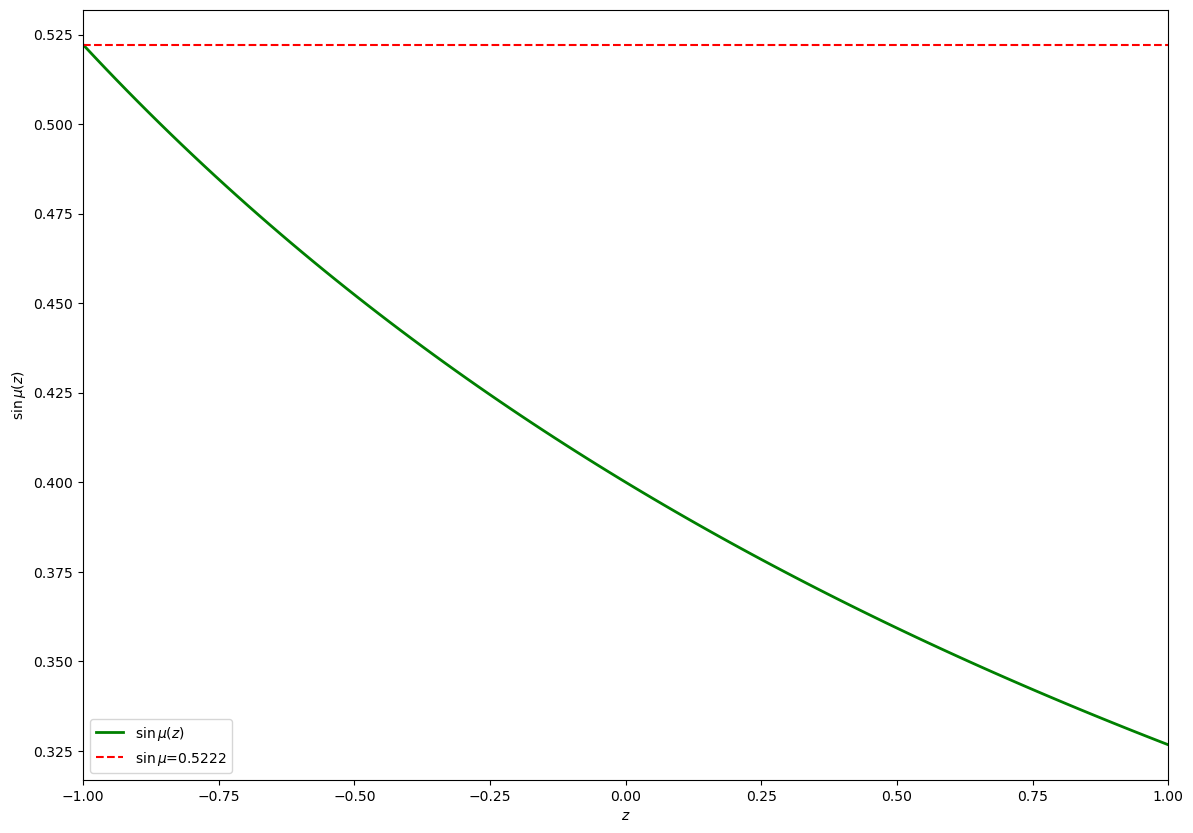

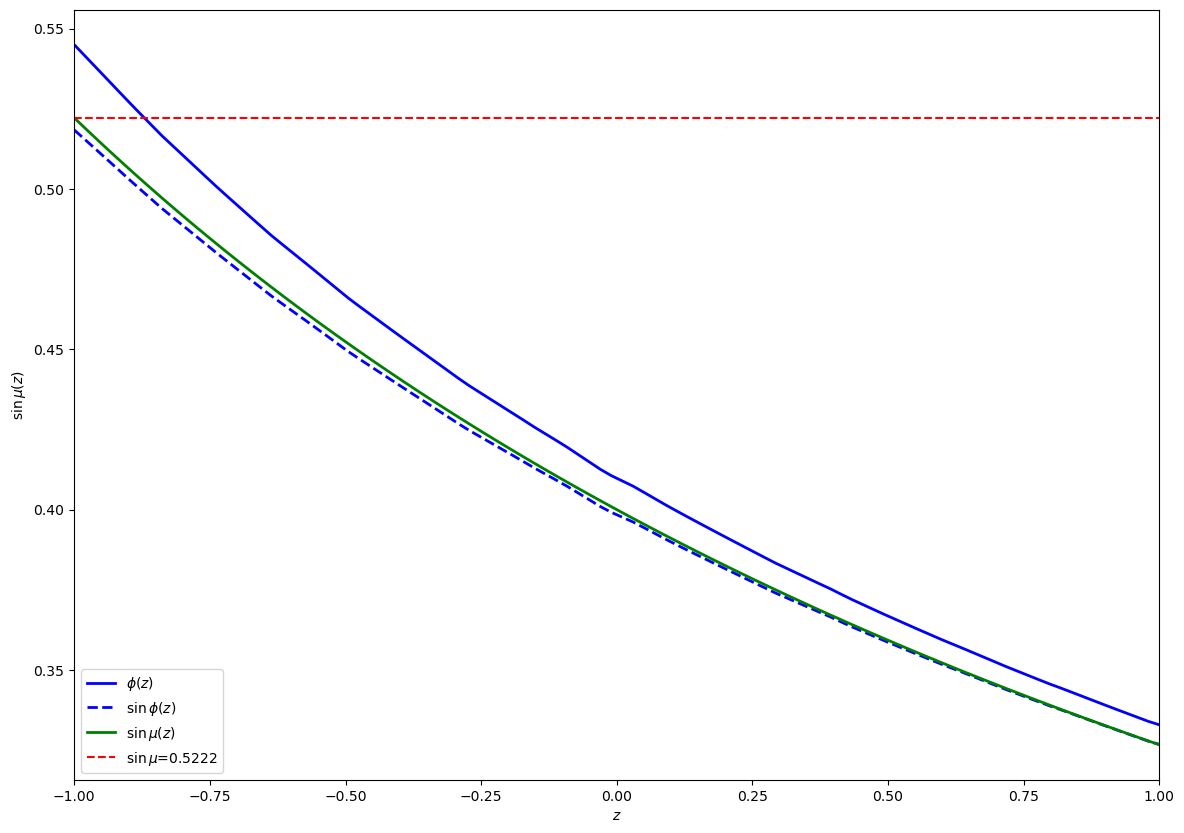

In [39]:
zpointseval_lin, phieval_lin, sinphieval_lin, eval_pt_loss_s_lin, eval_pt_loss_no_s_lin = eval_run(netsolver, params, device)

plot_phase(zpointseval_lin, phieval_lin)
plot_point_loss(zpointseval_lin, eval_pt_loss_s_lin, eval_pt_loss_no_s_lin)

integralz_lin = sin_mu_integral(params, device, netsolver, zpointseval_lin)
plot_sin_mu(zpointseval_lin, integralz_lin)

plot_summary(zpointseval_lin, phieval_lin, sinphieval_lin, integralz_lin)

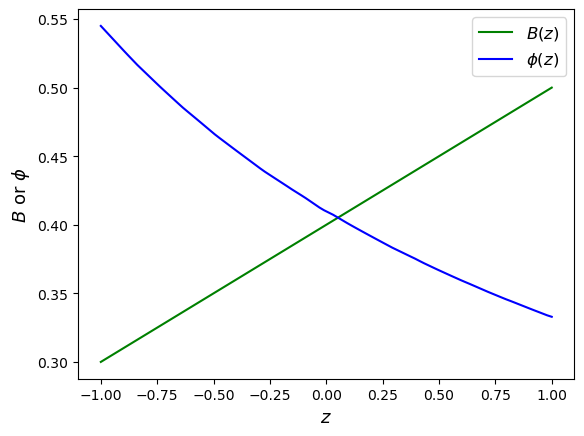

In [40]:
fig = plt.figure()
plt.plot(zpointseval_lin.cpu().numpy(), netsolver.mod_net(zpointseval_lin).cpu().numpy(), c='g')
plt.plot(zpointseval_lin.cpu().numpy(), phieval_lin, c='b')
plt.legend(['$B(z)$', '$\phi(z)$'], fontsize=12)
plt.xlabel('$z$', fontsize=13)
plt.ylabel('$B$ or $\phi$', fontsize=13)
plt.show()

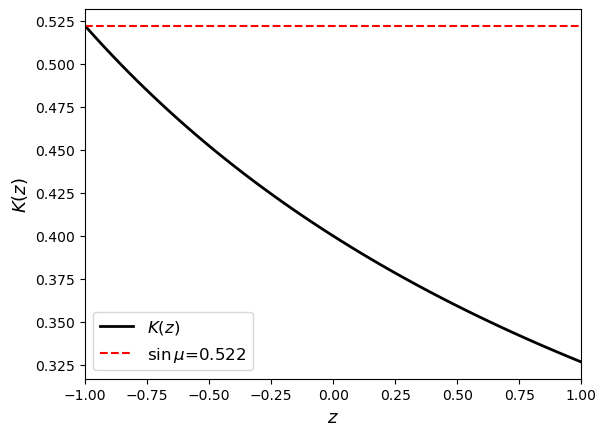

In [41]:
sinmu_lin = max(integralz_lin.cpu())

fig = plt.figure()
plt.plot(zpointseval_lin.cpu(),integralz_lin.cpu(), 'k-', linewidth = 2)   
plt.plot(zpointseval_lin.cpu(),sinmu_lin.repeat(integralz_lin.size(dim=0)), 'r--' )
plt.xlabel('$z$', fontsize=13)
plt.ylabel('$K(z)$', fontsize=13)    
plt.xlim([-1,1])
plt.legend(['$K(z)$','$\sin \mu$={}'.format(str(np.round(sinmu_lin.numpy(),3)))], fontsize=12)
plt.show()

##### Quadratic Modulus

In [42]:
from copy import deepcopy

params_new = deepcopy(params)
params_new['func_class'] = 'quadratic'
params_new['scan_param'] = 2.0

netsolver_new = train_run(params_new, device, seed_num=2, optim_name='Adam')

  0%|          | 0/5000 [00:00<?, ?epoch/s]

Evaluation and pictures

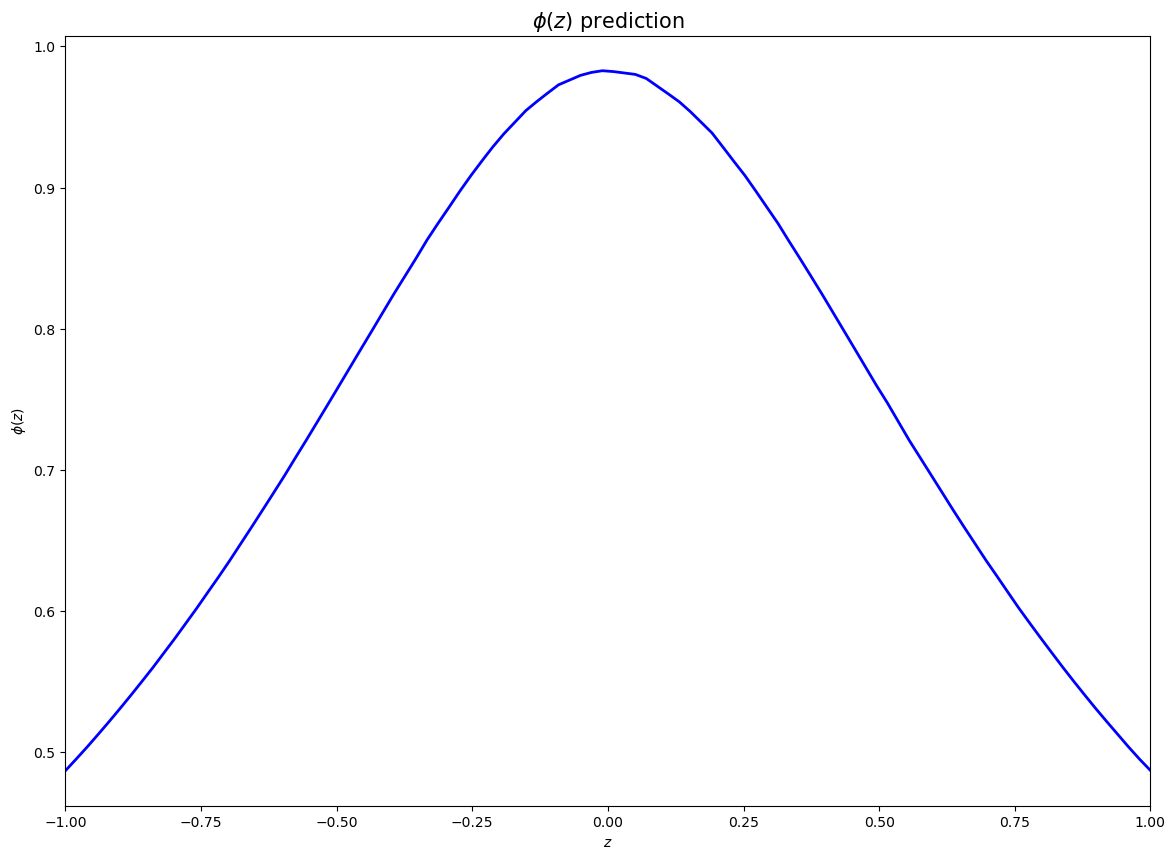

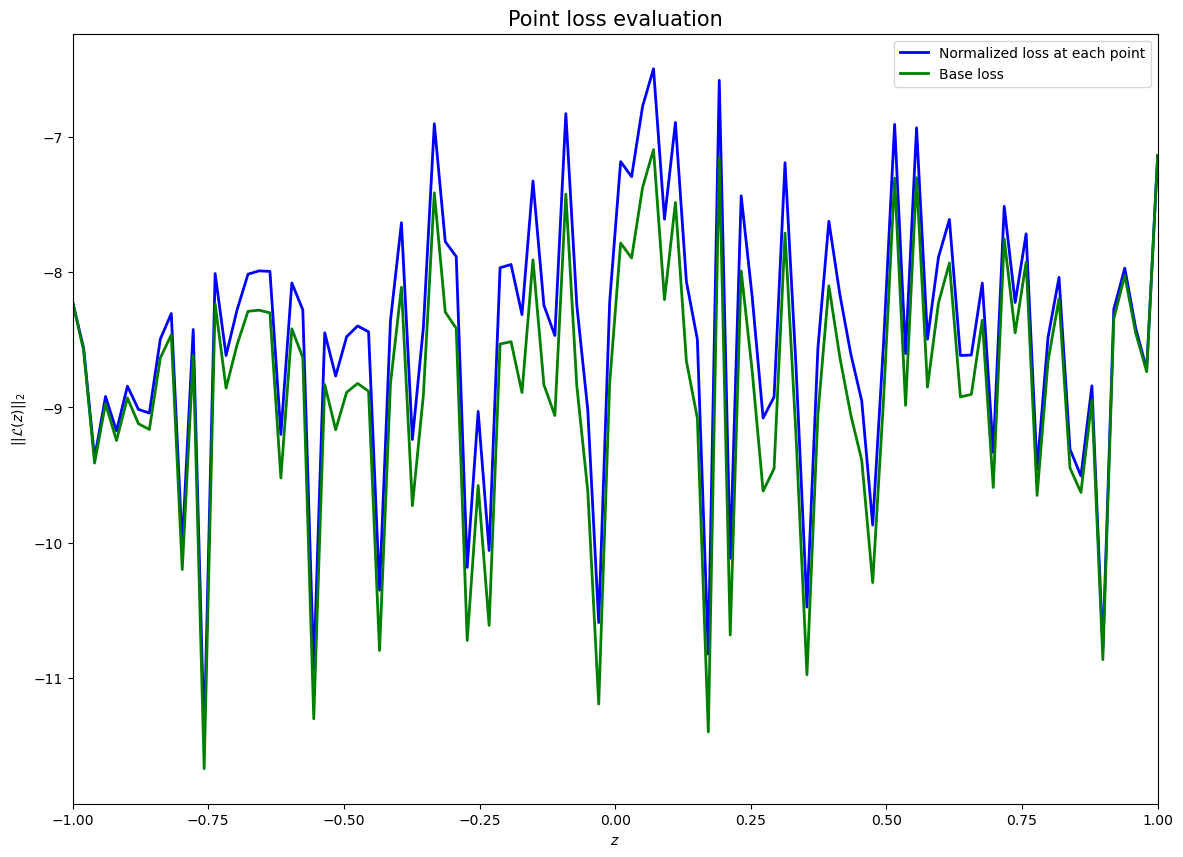

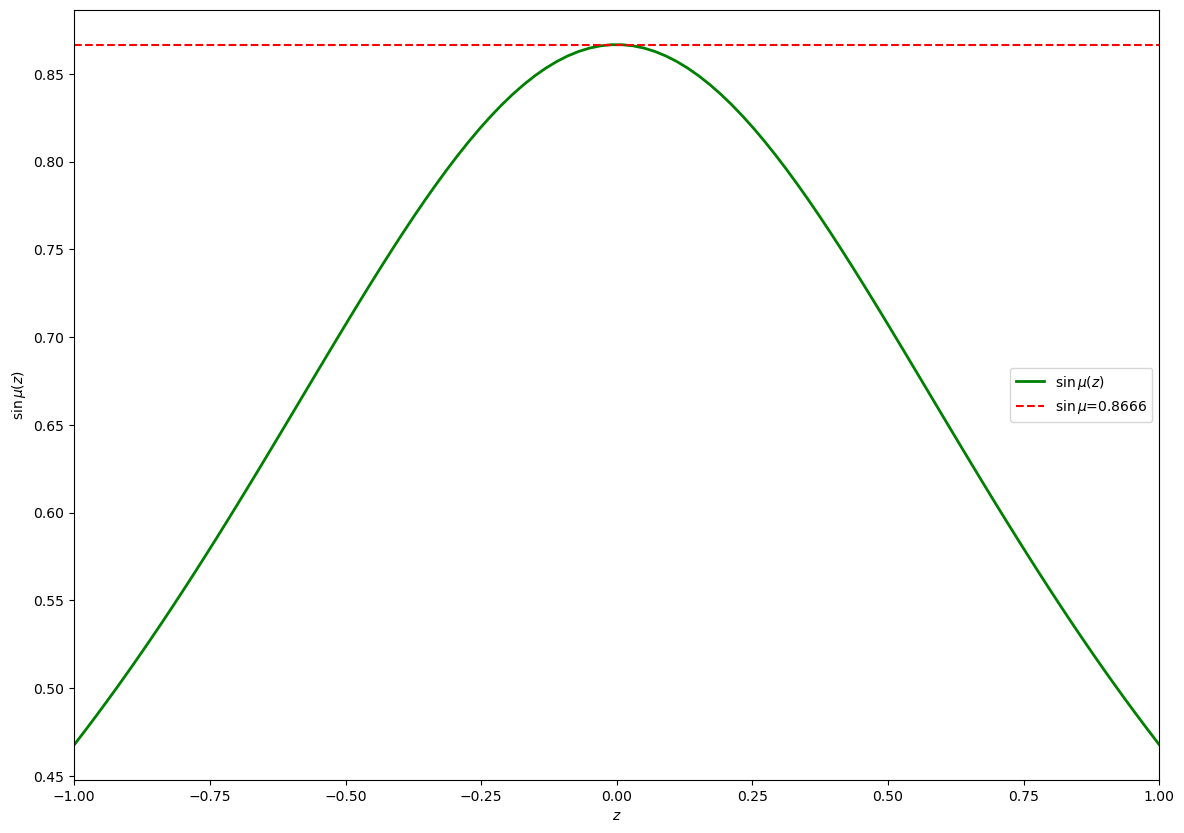

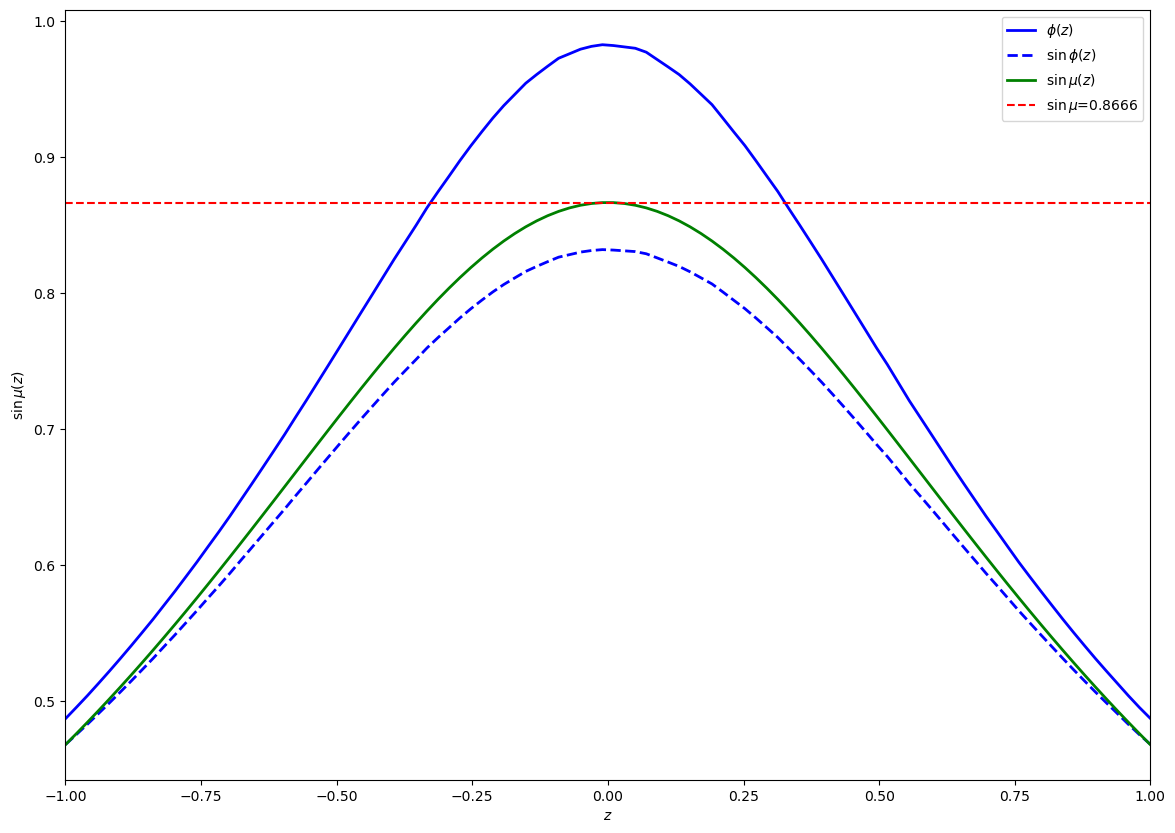

In [43]:
zpointseval_quad, phieval_quad, sinphieval_quad, eval_pt_loss_s_quad, eval_pt_loss_no_s_quad = eval_run(netsolver_new, params_new, device)

plot_phase(zpointseval_quad, phieval_quad)
plot_point_loss(zpointseval_quad, eval_pt_loss_s_quad, eval_pt_loss_no_s_quad)

integralz_quad = sin_mu_integral(params_new, device, netsolver_new, zpointseval_quad)
plot_sin_mu(zpointseval_quad, integralz_quad)

plot_summary(zpointseval_quad, phieval_quad, sinphieval_quad, integralz_quad)

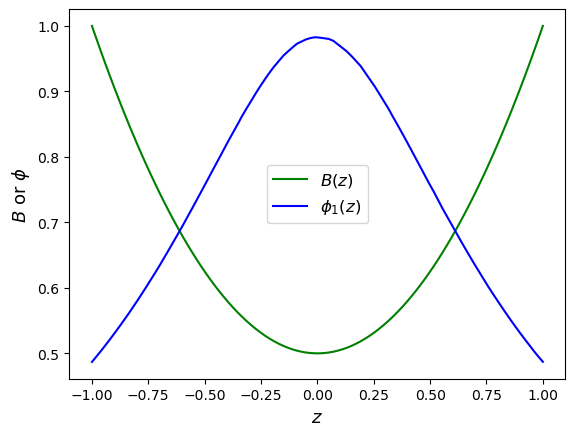

In [45]:
fig = plt.figure()
plt.plot(zpointseval_quad.cpu().numpy(), netsolver_new.mod_net(zpointseval_quad).cpu().numpy(), c='g')
plt.plot(zpointseval_quad.cpu().numpy(), phieval_quad, c='b')
plt.legend(['$B(z)$', '$\phi_1(z)$', '$\phi_2(z)$'], fontsize=12)
plt.xlabel('$z$', fontsize=13)
plt.ylabel('$B$ or $\phi$', fontsize=13)
plt.show()

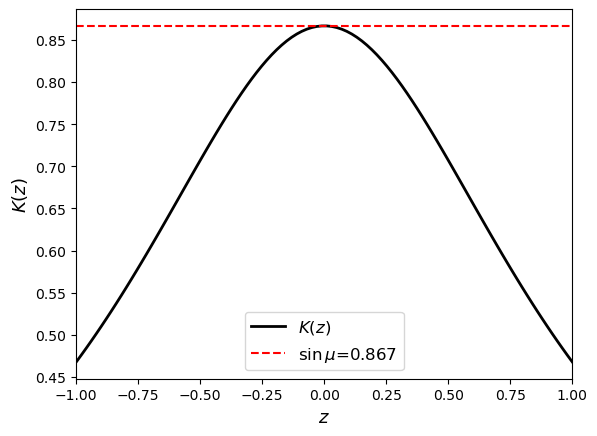

In [46]:
sinmu_quad = max(integralz_quad.cpu())

fig = plt.figure()
plt.plot(zpointseval_quad.cpu(),integralz_quad.cpu(), 'k-', linewidth = 2)   
plt.plot(zpointseval_quad.cpu(),sinmu_quad.repeat(integralz_quad.size(dim=0)), 'r--' )
plt.xlabel('$z$', fontsize=13)
plt.ylabel('$K(z)$', fontsize=13)    
plt.xlim([-1,1])
plt.legend(['$K(z)$','$\sin \mu$={}'.format(str(np.round(sinmu_quad.numpy(),3)))], fontsize=12)
plt.show()


#### Scan over Function runs

Compare the performance of the scaled and non scaled losses by taking $B(z)=z^2/2 + \epsilon$ as input, iterating over a range of $\epsilon$ values

##### Training runs

Start by training with the non-scaled loss

To reproduce the results we can bypass this step and load the appropriate data files later

In [47]:
scan_range = np.logspace(-5, np.log10(0.1), num=50)

phiresults = []
pt_losses_s = []
pt_losses_no_s = []
sinumus = []

for i, scan_param in tqdm(enumerate(scan_range)):

    params_scan = {'batch_size': 64,
                 'epochs_num': 2000,
                 'learning_rate': 0.003,
                 'repulsive_epochs': None,
                 'repulsive_type' : None,
                 'lr_scheduler': True, 
                 'beta1' : 0.9,
                 'beta2' : 0.999,
                 'integral_points': 25,
                 'method_int': 'trapz',
                 'activation': 'ReLU',
                 'layer_list': [64, 64, 64, 64],
                 'func_class': 'quadratic_path',
                 'final_layer': 'Tanh',
                 'loss': 'MSE',
                 'scaled_loss': False,
                 'scan_param': scan_param,
                 'num_nets' : 1,
                 'p_value': 2,
                 'lambda_repulsive': 0.0}
    
    netsolver_path = train_run(params_scan, device)
    
    zpointseval, phieval, sinphieval, pt_loss_s, pt_loss_no_s = eval_run(netsolver_path, params_scan, device)
    phiresults.append(phieval)
    pt_losses_s.append(pt_loss_s.cpu().numpy())
    pt_losses_no_s.append(pt_loss_no_s.cpu().numpy())
    integralz = sin_mu_integral(params_scan, device, netsolver_path, zpointseval)
    sinumus.append(max(integralz.cpu()))


0it [00:00, ?it/s]

  0%|          | 0/2000 [00:00<?, ?epoch/s]

Save the results in a dedicated folder

In [49]:
log_res_path = {'phiresults': np.array(phiresults),'pt_losses_s': np.array(pt_losses_s),'pt_losses_no_s': np.array(pt_losses_no_s),'sinmus': np.array(sinumus)}

path_save = ### Path to folder

for key in log_res_path.keys():
    end_path = '_non_scaled.npy'
    path = path_save + str(key) + end_path
    np.save(path, log_res_path[key])

Now train with the scaled loss

In [50]:
phiresults2 = []
pt_losses_s2 = []
pt_losses_no_s2 = []
sinmus2 = []

for i, scan_param in tqdm(enumerate(scan_range)):
    
    params_scan2 = deepcopy(params_scan)
    params_scan2['scaled_loss'] = True
    params_scan2['scan_param'] = scan_param
    
    netsolver_path2 = train_run(params_scan2, device)
    
    zpointseval, phieval, sinphieval, pt_loss_s, pt_loss_no_s = eval_run(netsolver_path2, params_scan2, device)
    phiresults2.append(phieval)
    pt_losses_s2.append(pt_loss_s.cpu().numpy())
    pt_losses_no_s2.append(pt_loss_no_s.cpu().numpy())

    integralz2 = sin_mu_integral(params_scan2, device, netsolver_path2, zpointseval)
    sinmus2.append(max(integralz2.cpu()))

0it [00:00, ?it/s]

  0%|          | 0/2000 [00:00<?, ?epoch/s]

In [52]:
log_res_path2 = {'phiresults': np.array(phiresults2),'pt_losses_s': np.array(pt_losses_s2),'pt_losses_no_s': np.array(pt_losses_no_s2),'sinmus': np.array(sinmus2)}

path_save = ##### PATH TO FOLDER

for key in log_res_path2.keys():
    end_path = '_scaled.npy'
    path = path_save + str(key) + end_path
    np.save(path, log_res_path2[key])

##### Plotting the losses

If we need to load the results we can do so. Otherwise we will use the results from the training run

In [56]:
load_results = True

if load_results:

    log_res_path = {'phiresults': [],'pt_losses_s': [],'pt_losses_no_s': [],'sinmus': []}
    log_res_path2 = {'phiresults': [],'pt_losses_s': [],'pt_losses_no_s': [],'sinmus': []}

    path_load = 'Data/Function_Scans/' # Replace by the appropriate path

    for key in log_res_path.keys():
        end_path = '_non_scaled.npy'
        end_path2 = '_scaled.npy'  
        path = path_load + str(key) + end_path
        path2 = path_load + str(key) + end_path2
        data = np.load(path)
        log_res_path[key] = data
        data2 = np.load(path2)
        log_res_path2[key] = data2

Calculate the average loss and plot the evolution as a function of $\epsilon$

In [60]:
mean_losses = np.mean(log_res_path['pt_losses_s'], axis=1)
mean_losses_no_s = np.mean(log_res_path['pt_losses_no_s'], axis=1)
mean_losses2 = np.mean(log_res_path2['pt_losses_s'], axis=1)
mean_losses_no_s2 = np.mean(log_res_path2['pt_losses_no_s'], axis=1)

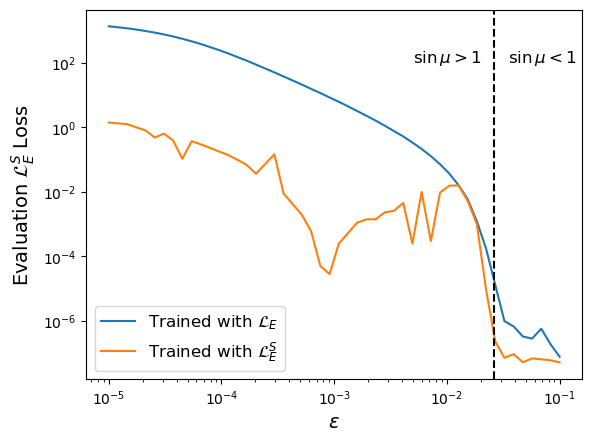

In [62]:
fig = plt.figure()
plt.plot(scan_range, mean_losses)
plt.plot(scan_range, mean_losses2)
plt.axvline(x = (10-np.sqrt(85))/30, color = 'k', label = 'axvline - full height', linestyle='--')


plt.legend(['Trained with $\mathcal{L}_E$', 'Trained with $\mathcal{L}_E^S$'], fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\epsilon$', fontsize = 14)
plt.ylabel('Evaluation $\mathcal{L}_E^S$ Loss', fontsize = 14)
plt.text(0.035,100, '$\sin \mu <1$', fontsize=12)
plt.text(0.005,100, '$\sin \mu >1$', fontsize=12)
plt.show()

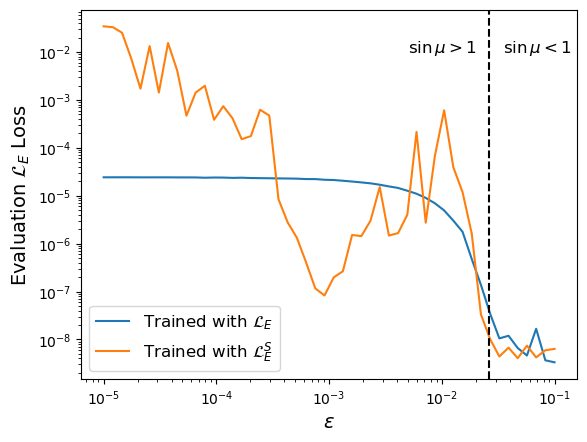

In [63]:
fig = plt.figure()
plt.plot(scan_range, mean_losses_no_s)
plt.plot(scan_range, mean_losses_no_s2)
plt.axvline(x = (10-np.sqrt(85))/30, color = 'k', label = 'axvline - full height', linestyle='--')
plt.legend(['Trained with $\mathcal{L}_E$', 'Trained with $\mathcal{L}_E^S$'], fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\epsilon$', fontsize = 14)
plt.ylabel('Evaluation $\mathcal{L}_E$ Loss', fontsize = 14)
plt.text(0.035, 0.01, '$\sin \mu <1$', fontsize=12)
plt.text(0.005, 0.01, '$\sin \mu >1$', fontsize=12)
plt.show()


##### Isolate two specific $\epsilon$ points and plot the resulting phases there

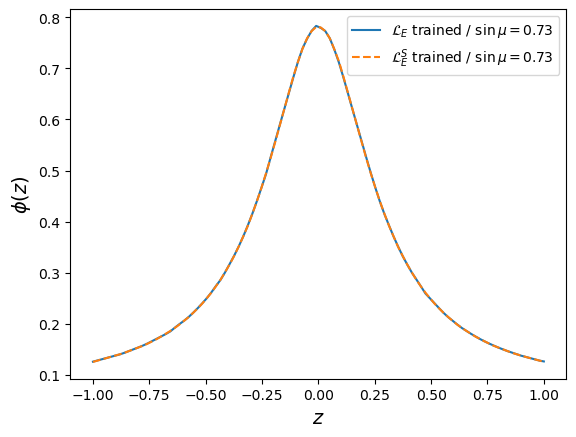

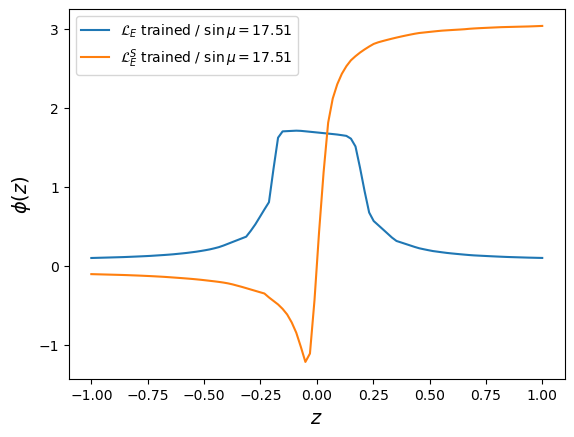

In [64]:
fig = plt.figure()
plt.plot(zpointseval.cpu(), log_res_path['phiresults'][45], color='tab:blue')
plt.plot(zpointseval.cpu(), log_res_path2['phiresults'][45], color='tab:orange', linestyle='--')
plt.legend(['$\mathcal{{L}}_E$ trained / $\sin \mu = {:.2f}$'.format(log_res_path['sinmus'][45]), '$\mathcal{{L}}_E^S$ trained / $\sin \mu = {:.2f}$'.format(log_res_path['sinmus'][45])], fontsize=10)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$\phi(z)$', fontsize=14)
plt.show()

fig = plt.figure()
plt.plot(zpointseval.cpu(), log_res_path['phiresults'][24], color='tab:blue')
plt.plot(zpointseval.cpu(), log_res_path2['phiresults'][24], color='tab:orange')
plt.legend(['$\mathcal{{L}}_E$ trained / $\sin \mu = {:.2f}$'.format(log_res_path['sinmus'][24]), '$\mathcal{{L}}_E^S$ trained / $\sin \mu = {:.2f}$'.format(log_res_path['sinmus'][24])], fontsize=10)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$\phi(z)$', fontsize=14)
plt.show()

#### Scans over families of moduli

The idea here is to parametrize the differential cross section as $B(z)=az+b >0$ say and map out the loss landscape. This will allow us to have a handle on the existence of a solution in the moduli space

##### Define the polynomial $B(z)$ module

In [67]:
class ModuleNetPolynomial(nn.Module):
    """
    Class for parametrizing the given differential cross section as a polynomial
    The input parameters correspond to the different weights of the polynomial
    """
    def __init__(self, polynomial_coeffs=None, device='cpu'):
        super(ModuleNetPolynomial, self).__init__()
        self.polynomial_coeffs = polynomial_coeffs
        self.device = device
        
    def forward(self, x):
        """
        Network forward pass is given by constructing the appropriate polynomial function
        """
        y = torch.zeros(x.size(), device=self.device)
        
        for i , coeff in enumerate(self.polynomial_coeffs):
            y = y + coeff * torch.pow(x, i)
        
        return y

##### Evaluation and plotting scripts

In [68]:
def eval_run_scans(trained_solver, params, device, steps_eval=100):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        
        # Also log the final loss values. Including the loss at individual z values
        trained_solver.scaled_loss = True
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        
        trained_solver.scaled_loss = False
        eval_loss_base = trained_solver.loss_function(zpointstest)
        
        # Look at sim mu value
        sinmu = max((sin_mu_integral(params, device, trained_solver, zpointstest)).cpu())

    return sinmu, eval_loss_scaled, eval_loss_base

In [156]:
def plt_boundaries_linear():
    """
    Plot the boundaries for the linear moduli
    """
    b1 = np.linspace(0,1,100)
    b2 = np.linspace(0,1.5,200)
    
    # The existence boundary
    a3 = b2
    a4 = 3/2 - 1/2*np.sqrt(3)*np.sqrt(3 + 4*b2 - 4*b2**2)
    plt.plot(b2,a3,'tab:gray', lw=8)
    plt.plot(b2,a4,'tab:gray', lw=8)
    
    # The sin mu =1 boundary
    a1 = 3/2 - (1/2)*np.sqrt(3)*np.sqrt(3 + 4*b1 - 4*b1**2)
    a2 = 3/2 - (1/2)*np.sqrt(3)*np.sqrt(3 - 4*b1 + 4*b1**2)
    plt.plot(b1,a1,'k-', lw=3)
    plt.plot(b1,a2,'k-', lw=3)
    
def plt_boundaries_quadratic():
    """
    Plot the boundaries for the linear moduli
    """
    d1 = np.linspace(0,1,100)
    d2 = np.linspace(0,(3/4)*(-1+np.sqrt(6)),200)
    cl1 = np.linspace(0, 5, 100)
    
    # The existence boundary
    c3 =(15-10*d2 - np.sqrt(5)*np.sqrt(45-24*d2-16*d2**2))/6
    c4 =(15-10*d2 + np.sqrt(5)*np.sqrt(45-24*d2-16*d2**2))/6
    dl1 = cl1*0
    plt.plot(d2,c3,'tab:gray', lw=8)
    plt.plot(d2,c4,'tab:gray', lw=8)
    plt.plot(dl1,cl1,'tab:gray', lw=8)
    
    # The sin mu =1 boundary
    c1 = -5*d1 + np.sqrt(5)*np.sqrt(d1*(3+2*d1))
    c2 = (15-10*d1 - np.sqrt(5)*np.sqrt(45-24*d1-16*d1**2))/6
    plt.plot(d1,c1,'k-', lw=3)
    plt.plot(d1,c2,'k-', lw=3)

In [160]:
def plot_contour_loss_curves(log_results, log_type='natural', type_b='linear'):
    # Plot the log of the loss
    if log_type == 'base10':
        loss_scale = np.log10(log_results['loss_scale'])
        loss_no_scale = np.log10(log_results['loss_no_scale'])
    elif log_type == 'natural':
        loss_scale = np.log(log_results['loss_scale'])
        loss_no_scale = np.log(log_results['loss_no_scale'])
    else:
        raise NotImplemented
        
    sin_mu = log_results['sinmu']
    
    min_a = min(log_results['params'][:,0])
    max_a = max(log_results['params'][:,0])
    min_b = min(log_results['params'][:,1])
    max_b = max(log_results['params'][:,1])
    
    fig = plt.figure(figsize=(10, 10))

    im1= plt.imshow(loss_scale, extent=[min_b,max_b,min_a,max_a], cmap='jet', vmax=-2, origin='lower', aspect='auto')       
    plt.xlabel('$b$ parameter')
    plt.ylabel('$a$ parameter')    
    plt.title('Normalized loss lanscape', fontsize = 15)
    if type_b == 'linear':
        plt_boundaries_linear()
    elif type_b == 'quadratic':
        plt_boundaries_quadratic()
        ax = fig.gca()
        offset_pixel = (1/30)/2
    circle1 = plt.Circle(( 0.818- (offset_pixel) , 2.455- (offset_pixel) ), 0.1 , facecolor="none", edgecolor='black', lw=2)
    circle2 = plt.Circle(( 0.612- (offset_pixel) , 3.061- (offset_pixel) ), 0.1 , facecolor="none", edgecolor='black', lw=2)
    ax.add_artist(circle1)
    ax.add_artist(circle2)
        
    cbar = plt.colorbar(im1,fraction=0.036)
    cbar.ax.set_title('$\log_{10} \mathcal{L}_E^S$', fontsize=16)
    plt.show()
    plt.close(fig)
    
    fig2 = plt.figure(figsize=(10, 10))

    im2=plt.imshow(loss_no_scale, extent=[min_b,max_b,min_a,max_a], cmap='jet', vmax=-2, origin='lower', aspect='auto')       
    plt.xlabel('$b$ parameter')
    plt.ylabel('$a$ parameter')    
    plt.title('Base loss lanscape', fontsize = 15)
    if type_b == 'linear':
        plt_boundaries_linear()
    elif type_b == 'quadratic':
        plt_boundaries_quadratic()
    cbar = plt.colorbar(im2,fraction=0.036)
    cbar.ax.set_title('$\log_{10} \mathcal{L}_E$', fontsize=16)
    plt.show()
    plt.close(fig2)
    
        
    fig3 = plt.figure(figsize=(10, 10))

    im3=plt.imshow(sin_mu, extent=[min_b,max_b,min_a,max_a], cmap='jet', vmax=1.5, origin='lower',  aspect='auto')       
    plt.xlabel('$b$ parameter')
    plt.ylabel('$a$ parameter')    
    plt.title('$\sin \mu$ landscape', fontsize = 15)
    if type_b == 'linear':
        plt_boundaries_linear()
    elif type_b == 'quadratic':
        plt_boundaries_quadratic()
    cbar = plt.colorbar(im3,fraction=0.036)
    cbar.ax.set_title('$\sin \mu$', fontsize=16)
    plt.show()
    plt.close(fig3)

##### Main scanning loop over  $B(z) = az+b$

Note: For a 75$\times$60 grid this will take a very long time (order of days). To generate results we run this piece of code on a cluster. Can skip to simply load results

In [72]:
num_a = 75
num_b = 60

scan_range_a = np.linspace(-0.5, 2.0, num=num_a)
scan_range_b = np.linspace(0, 2.0, num=num_b)
param_grid = np.dstack(np.meshgrid(scan_range_a, scan_range_b)).reshape(-1, 2)


log_res = {'params':param_grid, 'sinmu':np.empty([num_a, num_b]), 'loss_scale':np.empty([num_a, num_b]), 'loss_no_scale':np.empty([num_a, num_b])}

for i, params_lin in tqdm(enumerate(param_grid)):
    
    a_index = i % num_a
    b_index = int((i - i % num_a)/num_a)
    
    # Ensure that the differential cross section is positive for all z values
    if params_lin[1] > abs(params_lin[0]):

        params_scan = {'batch_size': 64,
                 'epochs_num': 2000,
                 'repulsive_epochs': None,
                 'repulsive_type' : None,
                 'learning_rate': 0.003,
                 'lr_scheduler': True, 
                 'beta1' : 0.9,
                 'beta2' : 0.999,
                 'integral_points': 25,
                 'method_int': 'trapz',
                 'activation': 'ReLU',
                 'layer_list': [64, 64, 64, 64],
                 'func_class': None,
                 'final_layer': 'Tanh',
                 'loss': 'MSE',
                 'scaled_loss': True,
                 'scan_param': None,
                 'num_nets' : 1,
                 'p_value': 2,
                 'lambda_repulsive': 0.0}
        
        
        # Initiallize with the new input  B(z)
        modnet = ModuleNetPolynomial(polynomial_coeffs=np.flip(params_lin), device=device)
        netsolver = train_run(params_scan, device, module_net=modnet)
        
        # Log the evaluation losses and the sin mu values
        sinmu, loss_scale, loss_no_scale = eval_run_scans(netsolver, params_scan, device)
        log_res['sinmu'][a_index, b_index] = sinmu.cpu().numpy()
        log_res['loss_scale'][a_index, b_index] = loss_scale.cpu().numpy()
        log_res['loss_no_scale'][a_index, b_index] = loss_no_scale.cpu().numpy()
    
    # For an invalid point in moduli space we log None
    else:
        log_res['sinmu'][a_index, b_index] = np.nan
        log_res['loss_scale'][a_index, b_index] = np.nan
        log_res['loss_no_scale'][a_index, b_index] = np.nan

0it [00:00, ?it/s]

  0%|          | 0/2000 [00:00<?, ?epoch/s]

##### Pictures for $B(z)=a z + b$

Can load the results from the cluster to yield the plots or need to rerun the previous piece of code

In [80]:
load_results = True

if load_results:
    
    
    num_a = 75
    num_b = 60

    scan_range_a = np.linspace(-0.5, 2.0, num=num_a)
    scan_range_b = np.linspace(0, 2.0, num=num_b)
    param_grid = np.dstack(np.meshgrid(scan_range_a, scan_range_b)).reshape(-1, 2)

    log_res = {'params':param_grid, 'sinmu':np.empty([num_a, num_b]), 'loss_scale':np.empty([num_a, num_b]), 'loss_no_scale':np.empty([num_a, num_b]),  'done': np.zeros([num_a, num_b])}
    path_load = 'Data/Polynomial_Scans/' ### PATH TO LOAD
    
    for key in log_res.keys():
        end_path = '_linear_scaled.npy'
        path = path_load + str(key) + end_path
        array_data = np.load(path) 
        log_res[key] = array_data

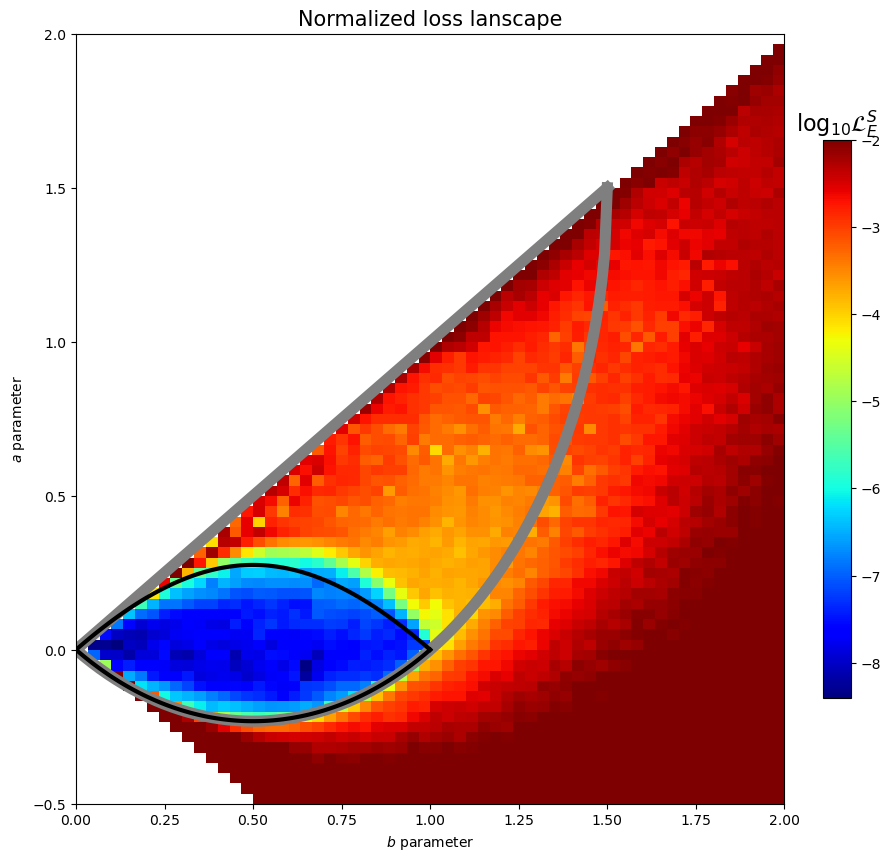

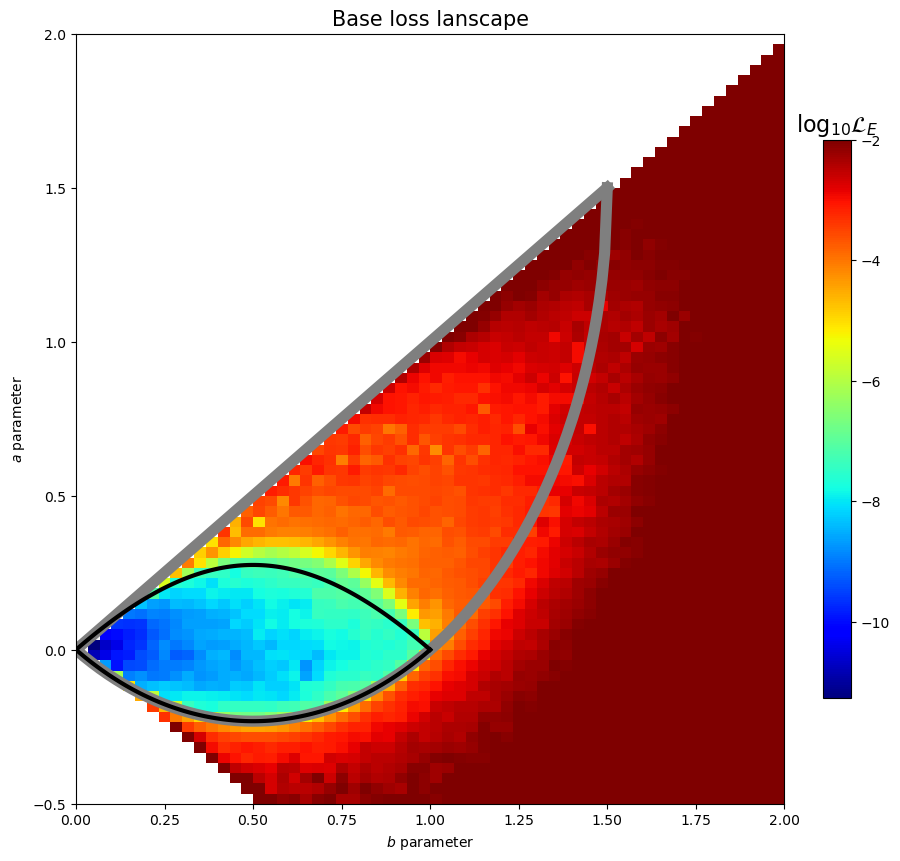

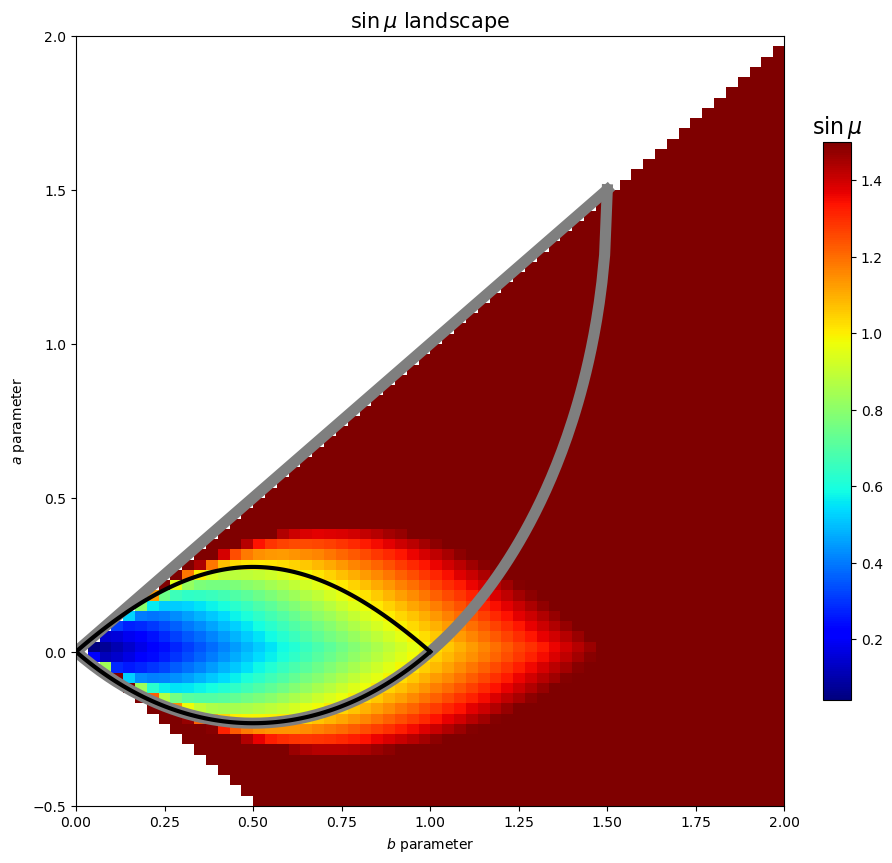

In [148]:
plot_contour_loss_curves(log_res, log_type='base10', type_b = 'linear')

##### Main scanning loop over  $B(z) = cz^2+d$

Note: For a 75$\times$60 grid this will take a very long time (order of days). To generate results we run this piece of code on a cluster. Can skip to simply load results

In [120]:
num_c = 180
num_d = 45

scan_range_c = np.linspace(-0.5, 5.5, num=num_c)
scan_range_d = np.linspace(0, 1.5, num=num_d)
param_grid2 = np.dstack(np.meshgrid(scan_range_c, scan_range_d)).reshape(-1, 2)

log_res2 = {'params':param_grid2, 'sinmu':np.empty([num_c, num_d]), 'loss_scale':np.empty([num_c, num_d]), 'loss_no_scale':np.empty([num_c, num_d])}

for i, params_quad in tqdm(enumerate(param_grid2)):
    
    c_index = i % num_c
    d_index = int((i - i % num_c)/num_c)
    
    # Ensure that the differential cross section is positive for all z values
    if params_quad[1] > - params_quad[0]:


        params_scan = {'batch_size': 64,
                     'epochs_num': 2000,
                     'repulsive_epochs': None,
                     'repulsive_type' : None,
                     'learning_rate': 0.003,
                     'lr_scheduler': True, 
                     'beta1' : 0.9,
                     'beta2' : 0.999,
                     'integral_points': 25,
                     'method_int': 'trapz',
                     'activation': 'ReLU',
                     'layer_list': [64, 64, 64, 64],
                     'func_class': None,
                     'final_layer': 'Tanh',
                     'loss': 'MSE',
                     'scaled_loss': True,
                     'scan_param': None,
                     'num_nets' : 1,
                     'p_value': 2,
                     'lambda_repulsive': 0.0}

        coeffs_scan = np.array([params_quad[1], 0.0, params_quad[0]])

        modnet = ModuleNetPolynomial(polynomial_coeffs=coeffs_scan, device=device)
        netsolver = train_run(params_scan, device, module_net=modnet)

        sinmu, loss_scale, loss_no_scale = eval_run_scans(netsolver, params_scan, device)
        log_res2['sinmu'][c_index, d_index] = sinmu.cpu().numpy()
        log_res2['loss_scale'][c_index, d_index] = loss_scale.cpu().numpy()
        log_res2['loss_no_scale'][c_index, d_index] = loss_no_scale.cpu().numpy()
    else:
        log_res2['sinmu'][c_index, d_index] = np.nan
        log_res2['loss_scale'][c_index, d_index] = np.nan
        log_res2['loss_no_scale'][c_index, d_index] = np.nan

0it [00:00, ?it/s]

  0%|          | 0/2000 [00:00<?, ?epoch/s]

  0%|          | 0/2000 [00:00<?, ?epoch/s]

  0%|          | 0/2000 [00:00<?, ?epoch/s]

##### Pictures for $B(z)=c z^2 + d$

Can load the results from the cluster to yield the plots or need to rerun the previous piece of code

In [142]:
load_results = True

if load_results:
    
    num_c = 180
    num_d = 45

    scan_range_c = np.linspace(-0.5, 5.5, num=num_c)
    scan_range_d = np.linspace(0, 1.5, num=num_d)
    param_grid2 = np.dstack(np.meshgrid(scan_range_c, scan_range_d)).reshape(-1, 2)

    log_res2 = {'params':param_grid2, 'sinmu':np.empty([num_c, num_d]), 'loss_scale':np.empty([num_c, num_d]), 'loss_no_scale':np.empty([num_c, num_d])}
    path_load = 'Data/Polynomial_Scans/' ### PATH TO LOAD
    
    for key in log_res2.keys():
        end_path = '_quadratic_scaled.npy'
        path = path_load + str(key) + end_path
        array_data = np.load(path) 
        log_res2[key] = array_data

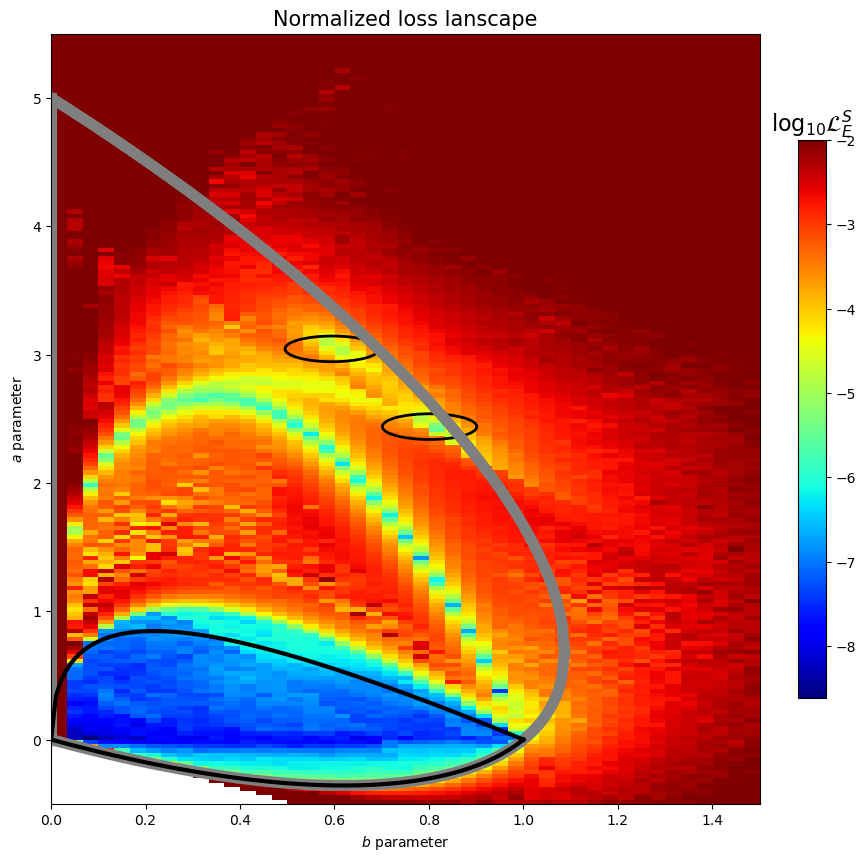

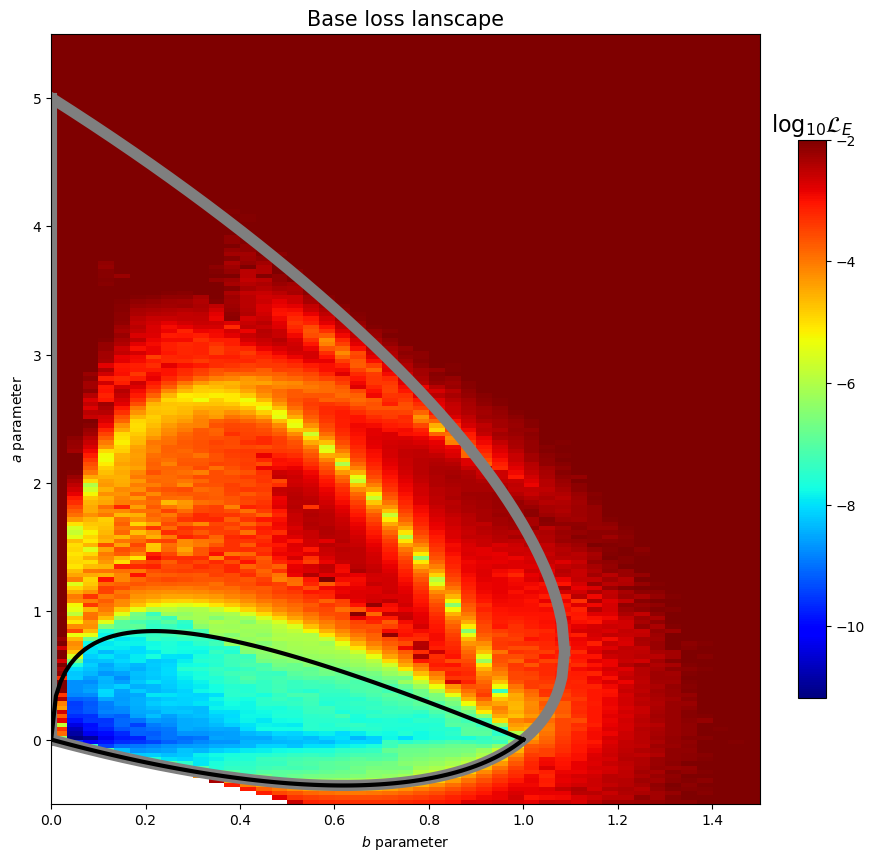

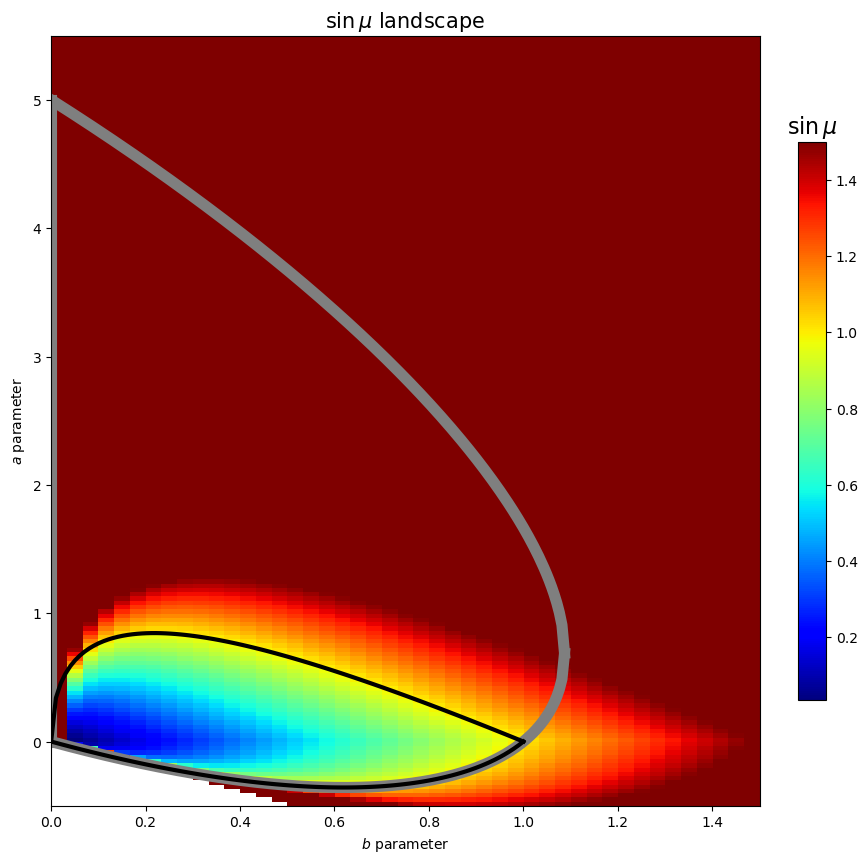

In [161]:
plot_contour_loss_curves(log_res2, log_type='base10', type_b='quadratic')

##### $L=3$ solution close to a quadratic $B(z)$

In [162]:
def analytic_close(z):
    """
    Define the analytic solution that has a modulus that is close to a quadratic one
    """
    
    delta_0 = 2.05132
    delta_1 = 0.457788
    delta_2 = -3.13145
    delta_3 = -3.12802
    
    return np.sin(delta_0) * np.exp(delta_0 * 1j)+ 3*z*np.sin(delta_1) * np.exp(delta_1 * 1j) + 5*(3*z**2-1)*np.sin(delta_2) * np.exp(delta_2 * 1j)/2 + 7*(5*z**3-3*z)*np.sin(delta_3) * np.exp(delta_3 * 1j)/2

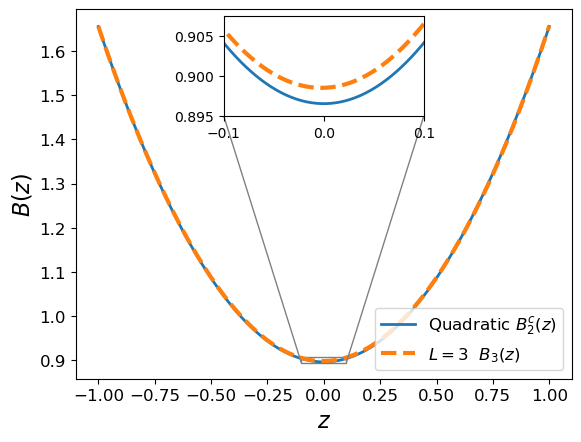

In [166]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


zpt = np.linspace(-1,1,400)

# The L=3 amplitude
mod_close = np.abs(analytic_close(zpt))

# The B(z) quadratic amplitude
mod_quad =22*zpt**2/29 + 26/29

fig = plt.figure()
plt.plot(zpt, mod_quad, lw=2)
plt.plot(zpt, mod_close, '--', lw=3)
plt.xlabel('$z$', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('$B(z)$', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(['Quadratic $B_2^c(z)$', '$L=3$  $B_3(z)$'], fontsize=12,loc='lower right')
ax = plt.gca()

axins = inset_axes(ax, 2, 1, loc=9) 
axins.plot(zpt, mod_quad, lw=2)
axins.plot(zpt, mod_close, '--', lw=3)
axins.set_xlim(-0.1,0.1)
axins.set_ylim(0.895, 0.9075)
axins.xaxis.set_ticks(np.arange(-0.1, 0.11, 0.1))


mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

plt.show()

Train the network for more epochs at the $B(z)$ considered and extract the phase

In [167]:
paramstest = {'batch_size': 64,
         'epochs_num': 5000,
         'learning_rate': 0.003,
         'repulsive_epochs': None,
         'repulsive_type' : None,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'func_class': None,
         'loss': 'MSE',
         'scaled_loss': True,
         'scan_param': None,
         'num_nets' : 1,
         'p_value': 2,
         'lambda_repulsive': 0.0}

modnettest = ModuleNetPolynomial(polynomial_coeffs=np.array([26/29,0.0,22/29]), device=device)

In [168]:
netsolvertest = train_run(paramstest, device, seed_num=42, optim_name='Adam', module_net = modnettest)

  0%|          | 0/5000 [00:00<?, ?epoch/s]

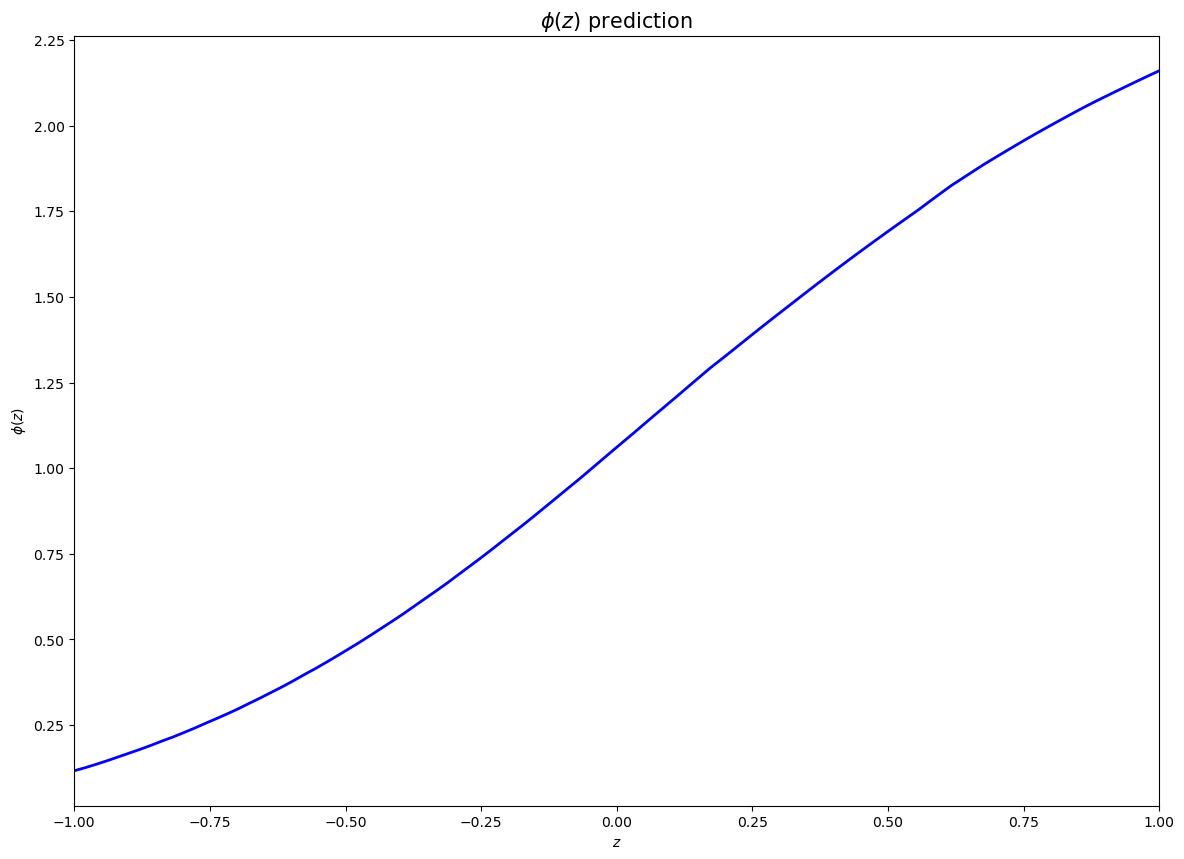

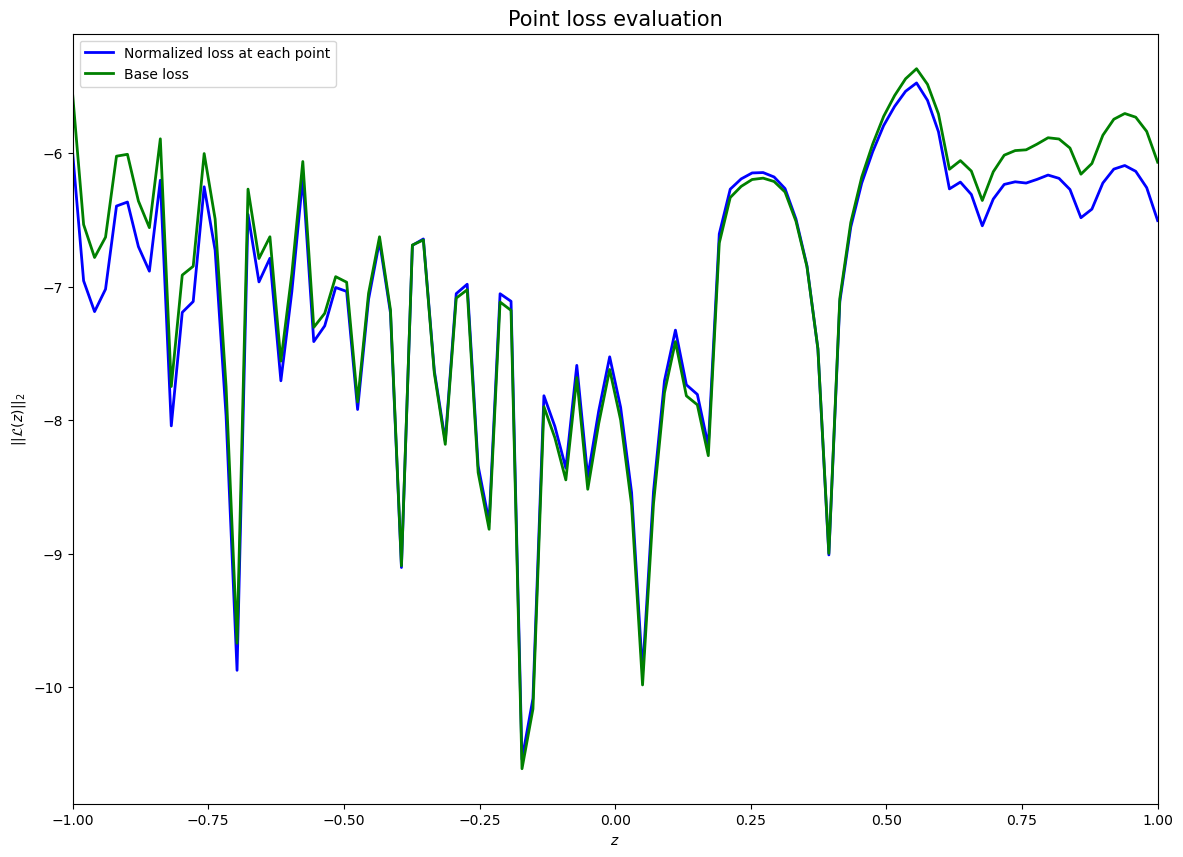

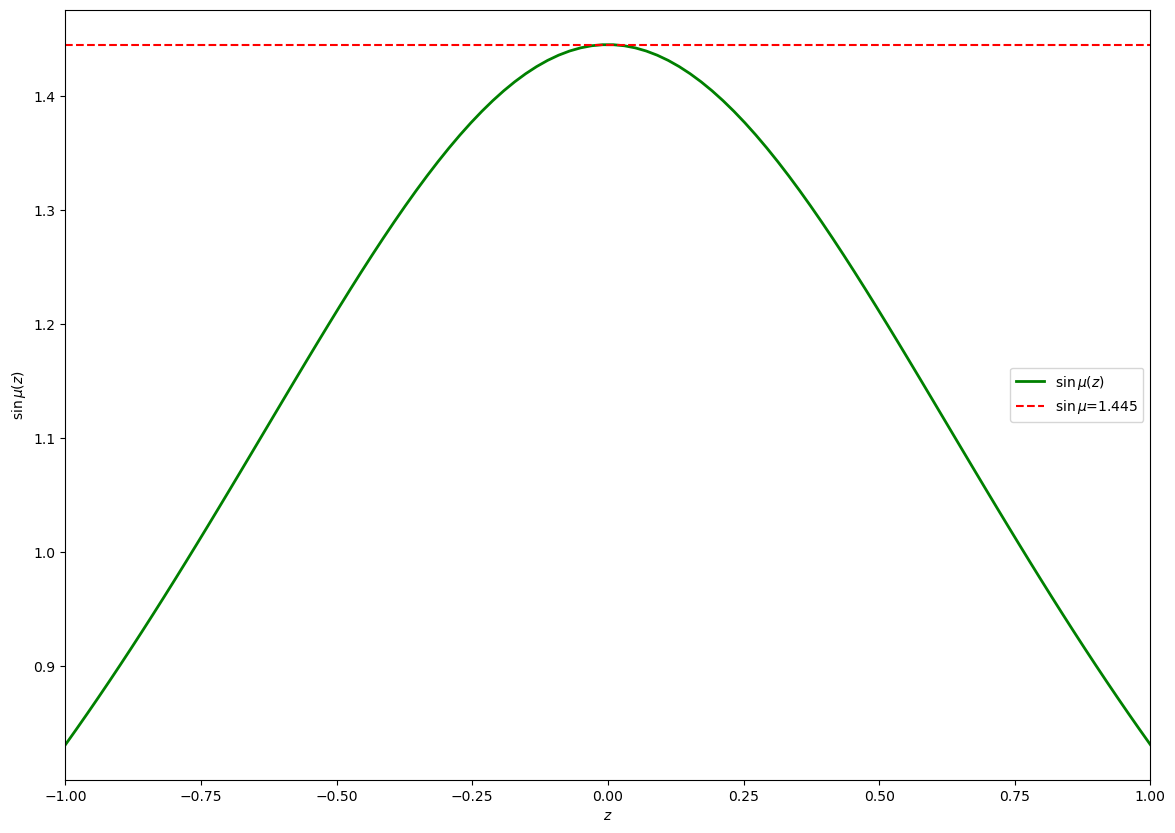

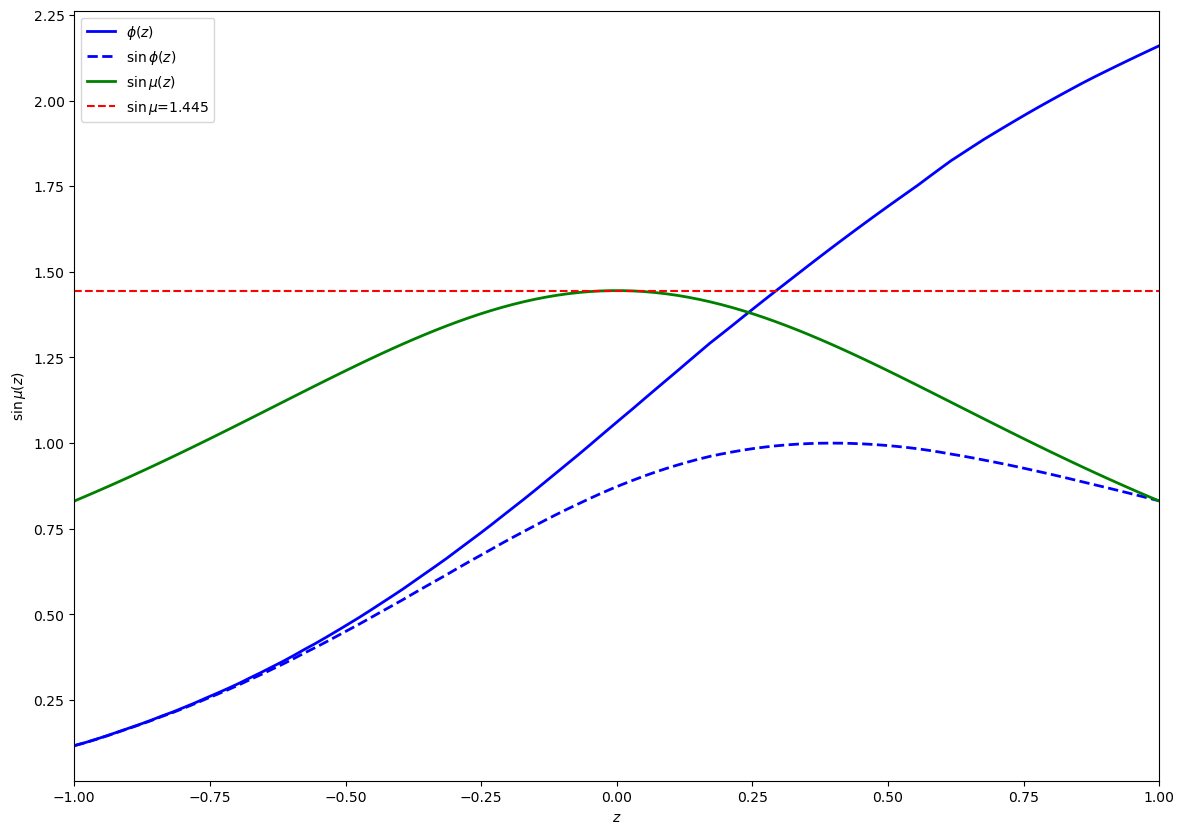

In [169]:
zpointseval_test, phieval_test, sinphieval_test, eval_pt_loss_s_test, eval_pt_loss_no_s_test = eval_run(netsolvertest, paramstest, device)

plot_phase(zpointseval_test, phieval_test)
plot_point_loss(zpointseval_test, eval_pt_loss_s_test, eval_pt_loss_no_s_test)

integralz_test = sin_mu_integral(paramstest, device, netsolvertest, zpointseval_test)
plot_sin_mu(zpointseval_test, integralz_test)

plot_summary(zpointseval_test, phieval_test, sinphieval_test, integralz_test)

Plot the $L=3$ solution phase and the one we have learned from the quadratic modulus

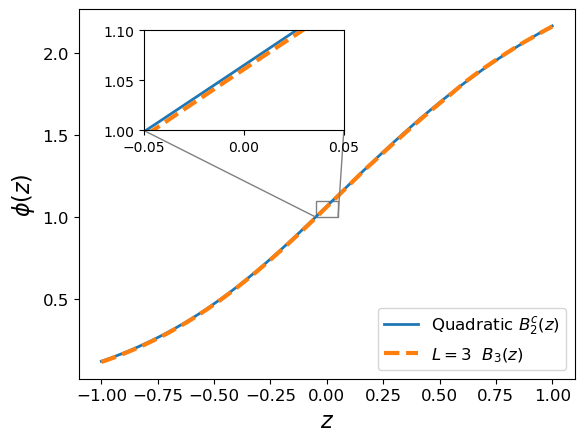

In [171]:
phase_close = math.pi - np.angle(analytic_close(zpt))

fig = plt.figure()
plt.plot(zpt, phase_close,  lw=2)
plt.plot(zpointseval_test.cpu().numpy(), phieval_test, '--',  lw=3)

plt.xlabel('$z$', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('$\phi(z)$', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(['Quadratic $B_2^c(z)$', '$L=3$  $B_3(z)$'],loc='lower right', fontsize=12)
ax = plt.gca()

axins = inset_axes(ax, 2, 1, loc=1, bbox_to_anchor=(0.55, 0.85),bbox_transform=ax.figure.transFigure) 
axins.plot(zpt, phase_close, lw=2)
axins.plot(zpointseval_test.cpu().numpy(), phieval_test, '--', lw=3)
axins.set_xlim(-0.05,0.05)
axins.set_ylim(1.0, 1.1)
axins.xaxis.set_ticks(np.arange(-0.05, 0.051, 0.05))


mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

plt.show()

### Ambiguity Recovery

#### Crichton Ambiguity definition

Out goal will be to recover the Crichton ambiguity via our Neural networks. For that purpose we define the appropriate $B(z)$ modulus

In [172]:
class ModuleNetCrichton(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self, scale_param=1):
        super(ModuleNetCrichton, self).__init__()
        self.scale_param = scale_param
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function. Can iterate on the overall scale if we want to
        """
        return torch.sqrt(1.38065 + 3.1118 *x - 1.60815*torch.pow(x,2) - 4.731*torch.pow(x,3) + 6.58* torch.pow(x,4))/self.scale_param # Crichton example

Define some plotters for the phases and moduli where we will want to compare to the original expression found in Crichton's paper

In [173]:
import matplotlib.pyplot as plt

def crichton_solutions(zpoints):
    """
    Analytic solution for the Crichton ambiguity (from the original paper)
    Take minus the phases shifts for one solution (just corresponding to the trivial ambiguity)
    """
    z = zpoints.cpu()
    sol1 = torch.angle((-5/2)*np.exp(-1j*math.pi/9)*(3*torch.pow(z,2)-1)*np.sin(math.pi/9)+np.exp(7*1j*math.pi/54)*np.sin(7*math.pi/54)+3*np.exp(869*1j*math.pi/3600)*z*np.sin(869*math.pi/3600))
    sol2 = torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(z,2)-1)*np.sin(math.pi/9)+np.exp(659*1j*math.pi/1200)*np.cos(59*math.pi/1200)-3*np.exp(-59*1j*math.pi/400)*z*np.sin(59*math.pi/400))
    
    return sol1, sol2

def plot_point_loss_crichton(zpoints, point_loss_data_ses, point_loss_data_noses):

    fig = plt.figure(figsize=(14, 10))
    
    for point_loss_data_s in point_loss_data_ses:
        plt.plot(zpoints.cpu(), np.log10(point_loss_data_s.cpu()), '-', linewidth = 2)  
    
    plt.gca().set_prop_cycle(None)
    for point_loss_data_nos in point_loss_data_noses:
        plt.plot(zpoints.cpu(), np.log10(point_loss_data_nos.cpu()), '--', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$\log_{10} ||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    legendstr = ['Network {} : Normalized point loss'.format(i+1) for i in range(len(point_loss_data_ses))] + ['Network {} : Base point loss'.format(i+1) for i in range(len(point_loss_data_noses))]
    plt.legend(legendstr)
    plt.show()
    plt.close(fig)
    
    
def plot_summary_crichton(zpoints, phipoints_list):
    
    fig3 = plt.figure(figsize=(14, 10))
    
    sol1, sol2 = crichton_solutions(zpoints)
    
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '--', linewidth = 2)   
    plt.plot(zpoints.cpu(),sol1, 'g', linewidth = 2)   
    plt.plot(zpoints.cpu(),sol2, 'k', linewidth = 2)   
    
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.xlim([-1,1])
    legend_nets = ['$\phi(z)$ network {}'.format(i+1) for i in range(len(phipoints_list))]
    plt.legend(legend_nets + ['$\phi_1(z)$ exact', '$\phi_2(z)$ exact'])
    plt.show()
    plt.close(fig3)

#### Recovering Crichton's solution

##### Starting with no repulsive loss

In [185]:
params = {'batch_size': 64,
         'epochs_num': 5000,
         'learning_rate': 0.003,
         'repulsive_epochs': None,
         'repulsive_type' : None,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'func_class': None,
         'loss': 'MSE',
         'scaled_loss': False,
         'scan_param': None,
         'num_nets': 2,
         'p_value': 2,
         'lambda_repulsive': 0.000}

In [186]:
crichtonnet = ModuleNetCrichton()
netsolver = train_run(params, device, module_net=crichtonnet, seed_num=42)

  0%|          | 0/5000 [00:00<?, ?epoch/s]

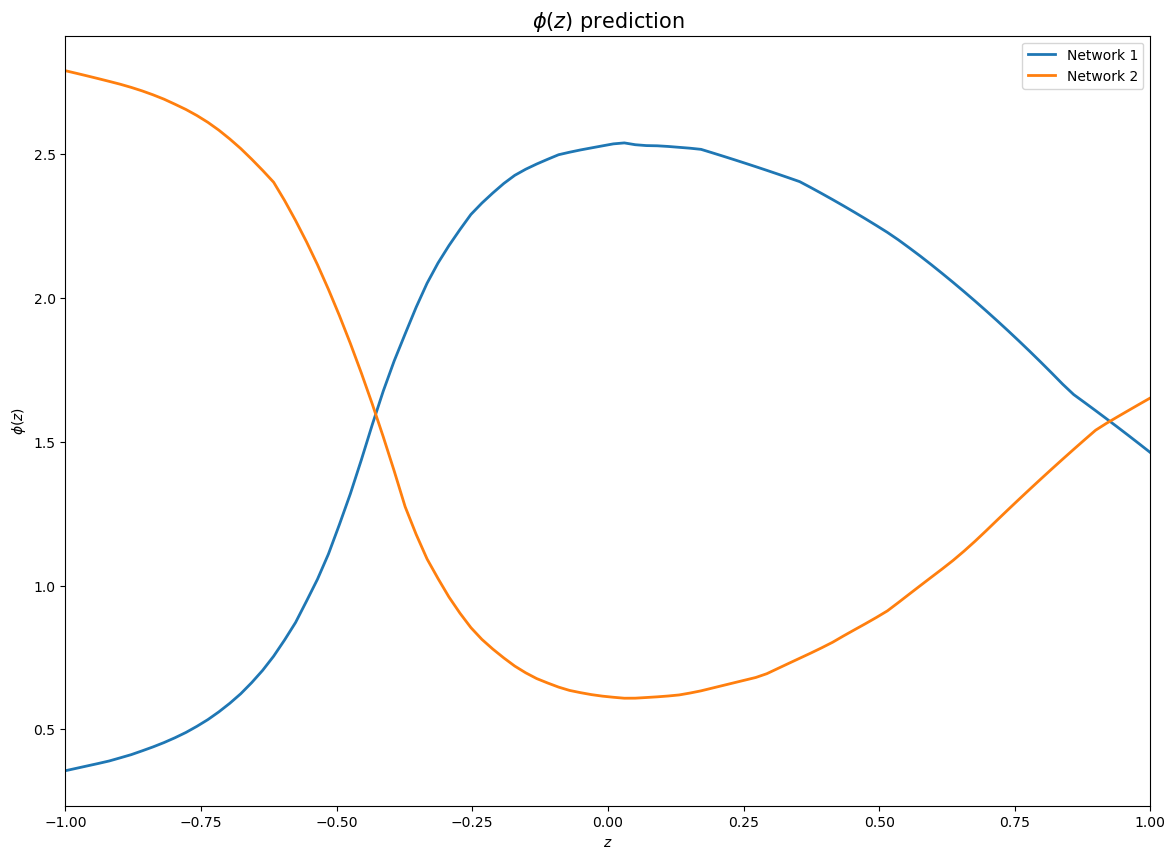

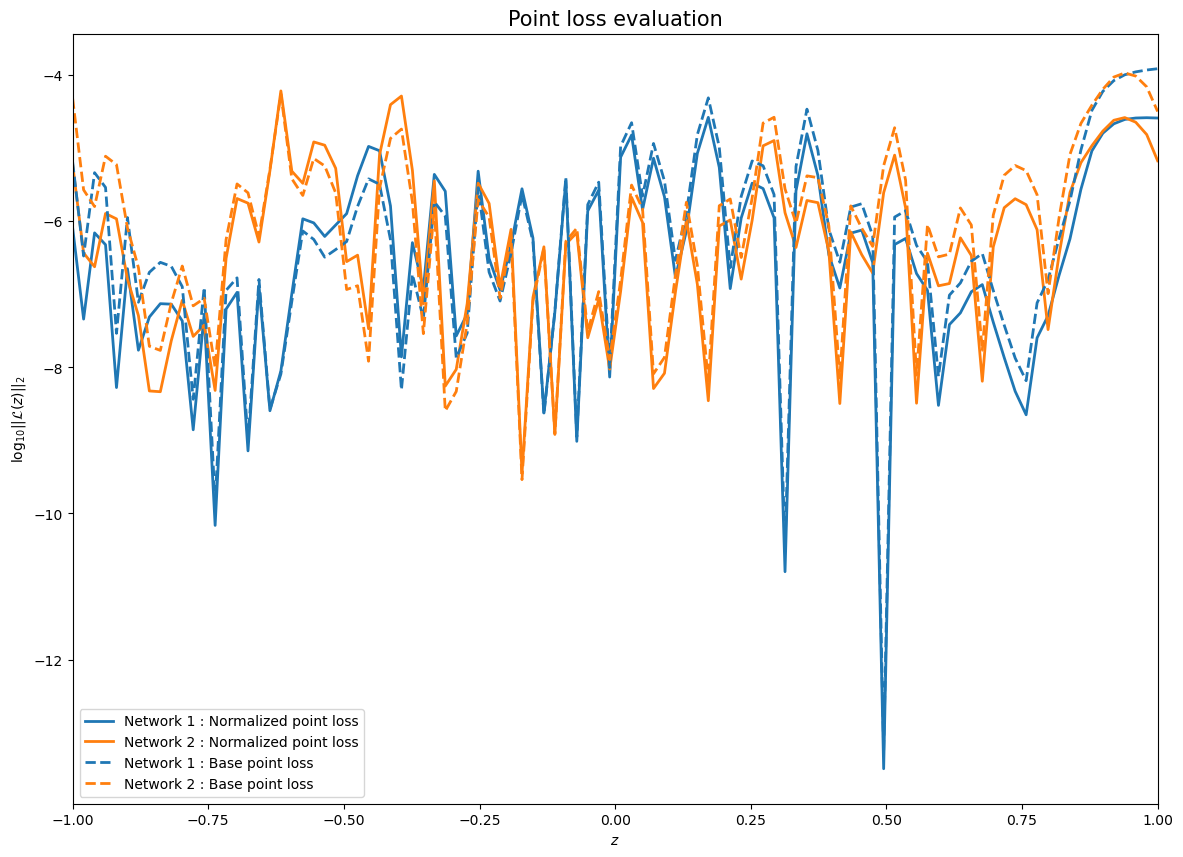

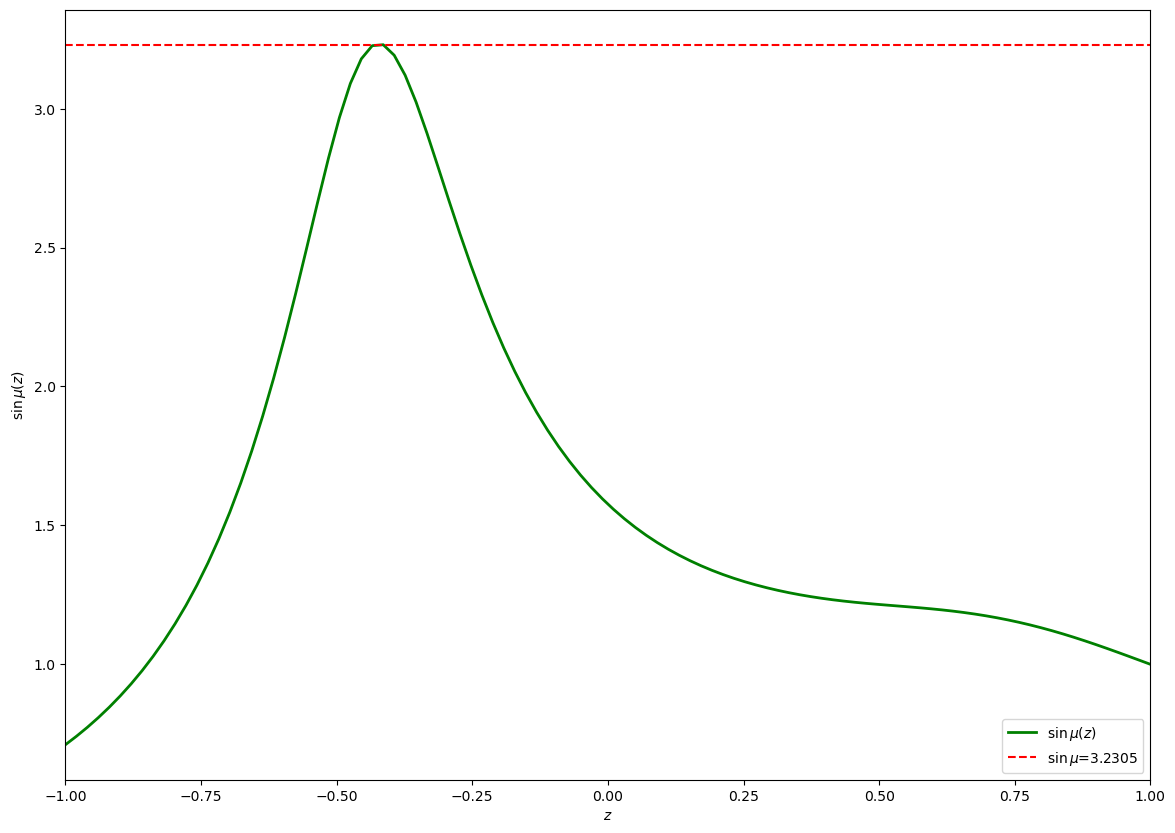

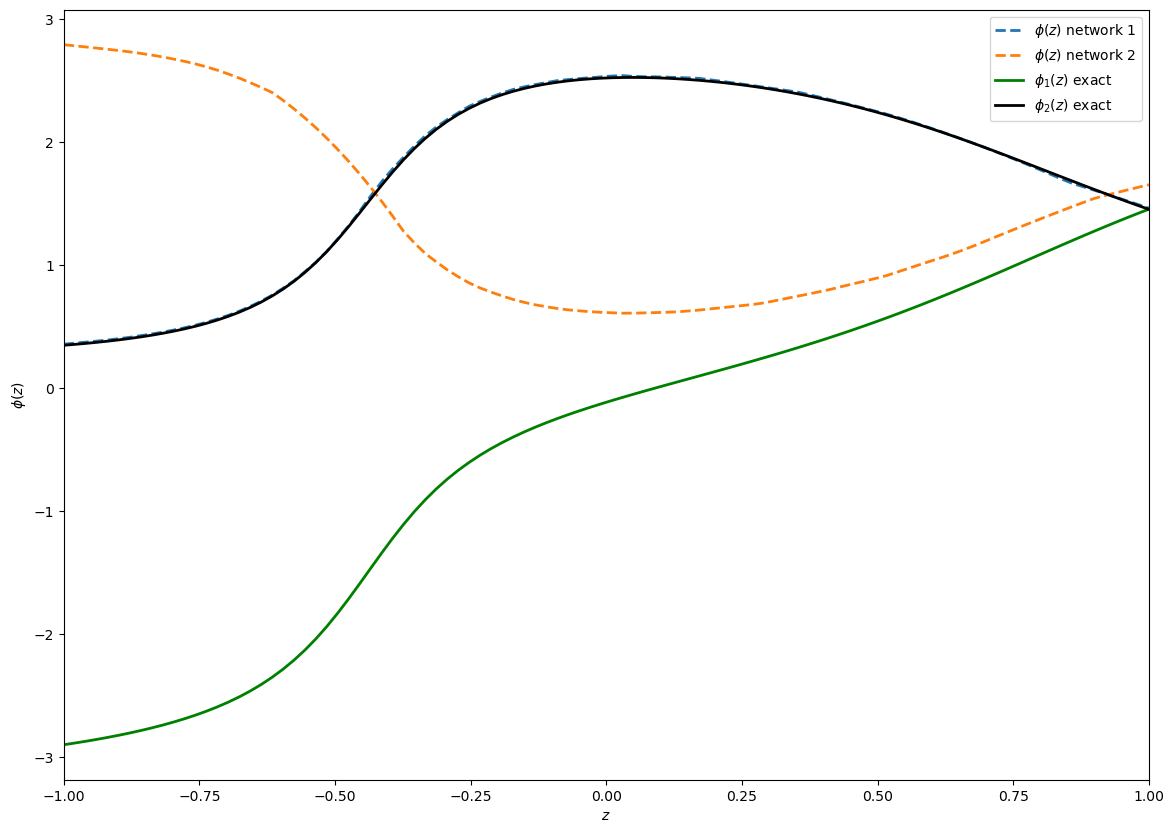

In [191]:
phievals = []
eval_pt_loss_ses = []
eval_pt_loss_no_ses= []

for i in range(params['num_nets']):
    if params['num_nets'] > 1: 
        netsolver.phi_net = netsolver.multi_nets[i]
    zpointseval, phieval, _, eval_pt_loss_s, eval_pt_loss_no_s = eval_run(netsolver, params, device)
    phievals.append(phieval)
    eval_pt_loss_ses.append(eval_pt_loss_s)
    eval_pt_loss_no_ses.append(eval_pt_loss_no_s)

plot_phases(zpointseval, phievals)
plot_point_loss_crichton(zpointseval, eval_pt_loss_ses, eval_pt_loss_no_ses)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz)

plot_summary_crichton(zpointseval, phievals)

Dedicated pictures

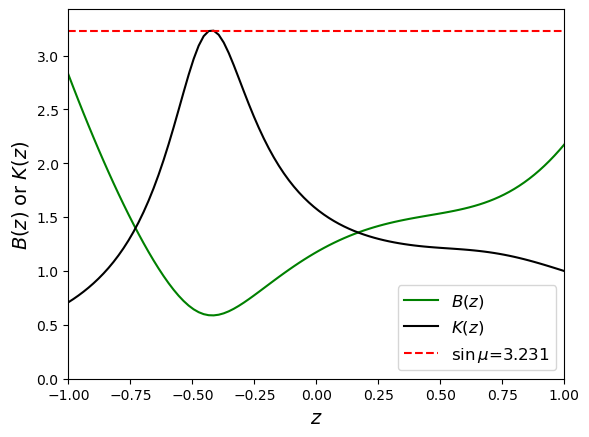

In [192]:
crichtonmod = crichtonnet(zpointseval).cpu().numpy()
sinmucrichton = max(integralz).cpu().numpy()

fig = plt.figure()

plt.plot(zpointseval.cpu().numpy(), crichtonmod, 'g')
plt.plot(zpointseval.cpu().numpy(), integralz.cpu().numpy(), 'k')
plt.plot(zpointseval_lin.cpu().numpy(),sinmucrichton.repeat(integralz.size(dim=0)), 'r--' )
plt.xlabel('$z$', fontsize=14)
plt.xlim([-1,1])
plt.ylabel('$B(z)$ or $K(z)$', fontsize=14)
plt.ylim([0, sinmucrichton+0.2])
plt.legend(['$B(z)$', '$K(z)$','$\sin \mu$={}'.format(str(np.round(sinmucrichton,3)))], fontsize=12)
plt.show()

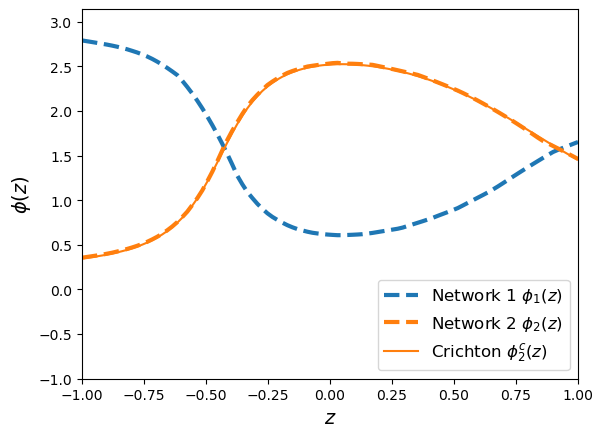

In [193]:
sol1, sol2 = crichton_solutions(zpointseval)

fig = plt.figure()
plt.plot(zpointseval.cpu().numpy(), phievals[1], '--', lw=3)
plt.plot(zpointseval.cpu().numpy(), phievals[0],  '--',lw=3)
plt.plot(zpointseval.cpu().numpy(), sol2, 'tab:orange')
plt.xlabel('$z$', fontsize=14)
plt.xlim([-1,1])
plt.ylabel('$\phi(z)$', fontsize=14)
plt.ylim([-1, math.pi])
plt.legend(['Network 1 $\phi_1(z)$', 'Network 2 $\phi_2(z)$', 'Crichton $\phi_2^c(z)$'], loc='lower right', fontsize=12)
plt.show()

##### Enabling the sharp repulsion loss

In [222]:
params = {'batch_size': 64,
         'epochs_num': 10000,
         'learning_rate': 0.003,
         'lr_scheduler': True,
         'repulsive_epochs': [200, 300],
         'repulsive_type' : 'sharp',
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list' : [64,64, 64, 64],
         'final_layer': 'Tanh',
         'func_class': None,
         'loss': 'MSE',
         'scaled_loss': False,
         'scan_param': None,
         'num_nets': 2,
         'p_value': 2,
         'lambda_repulsive': 1.0}

In [188]:
crichtonnet = ModuleNetCrichton()
netsolver_sharp = train_run(params, device, module_net=crichtonnet, seed_num=42, optim_name='Adam', log_loss=True)

  0%|          | 0/10000 [00:00<?, ?epoch/s]

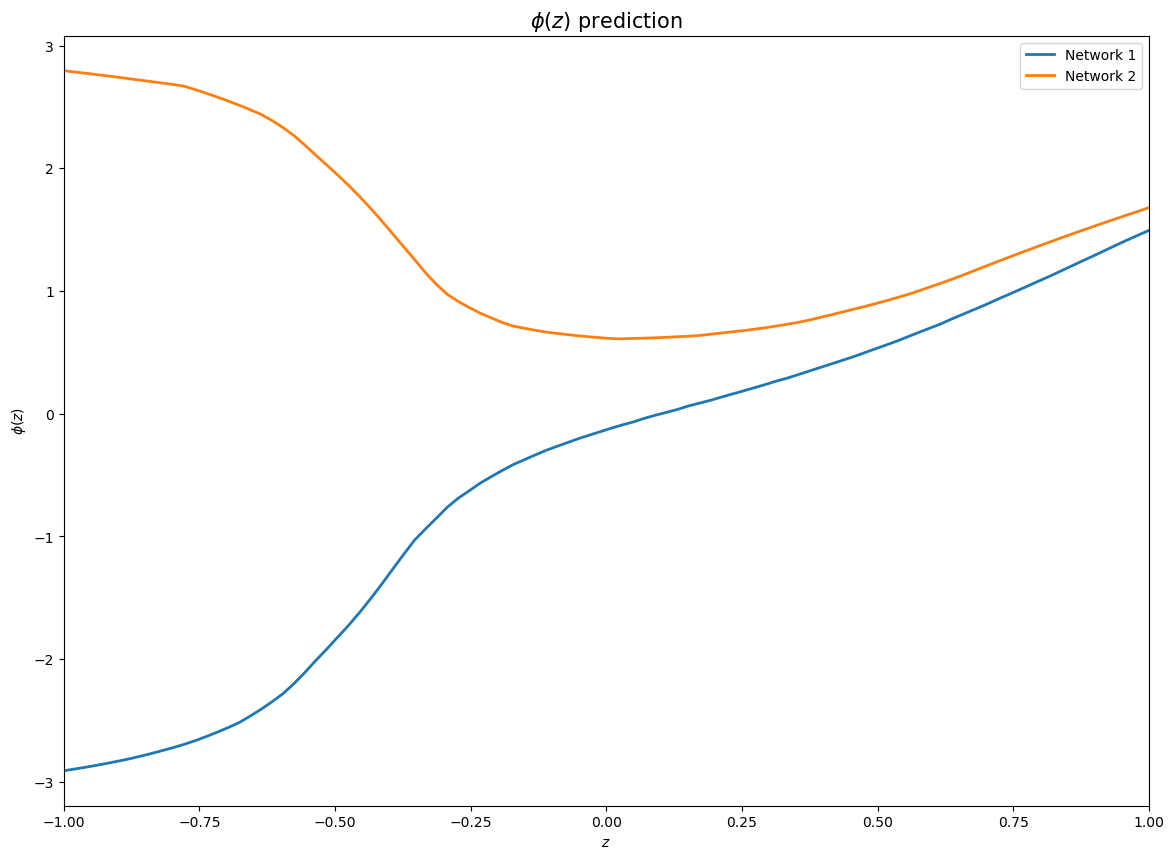

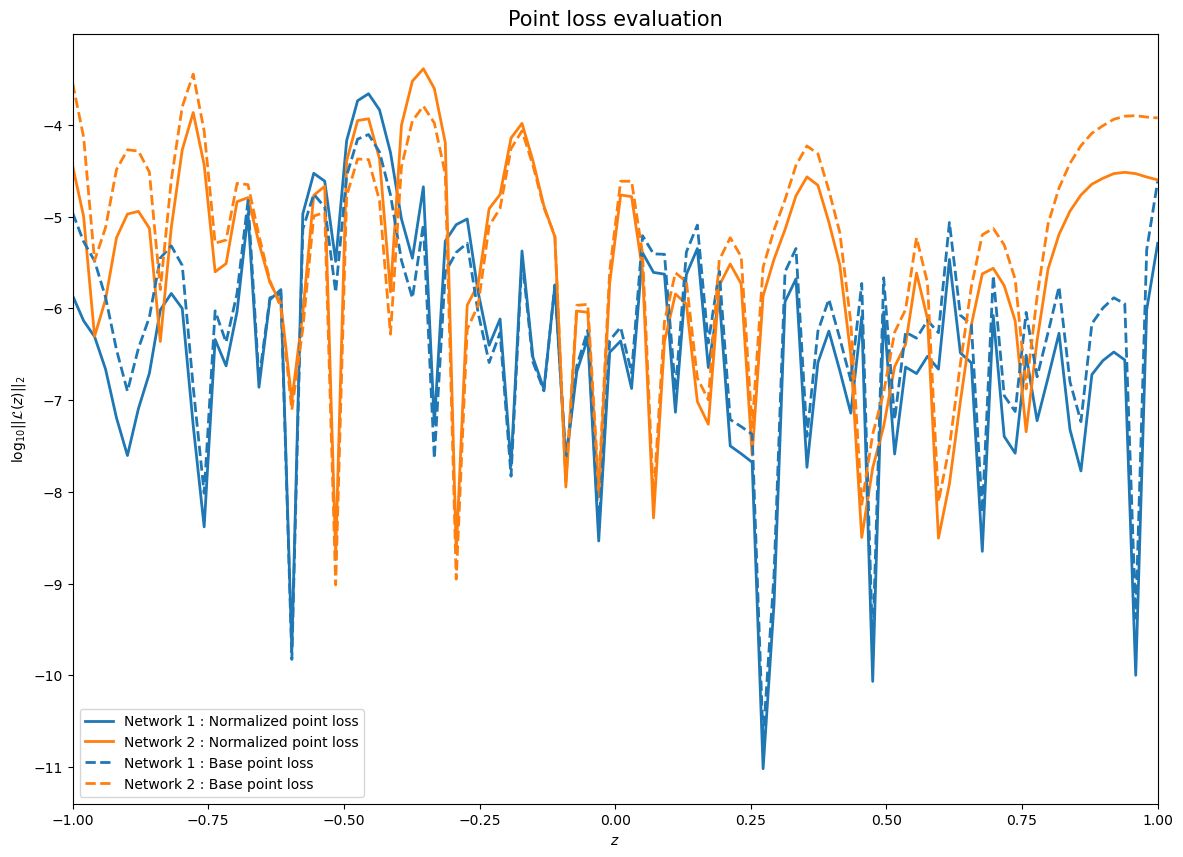

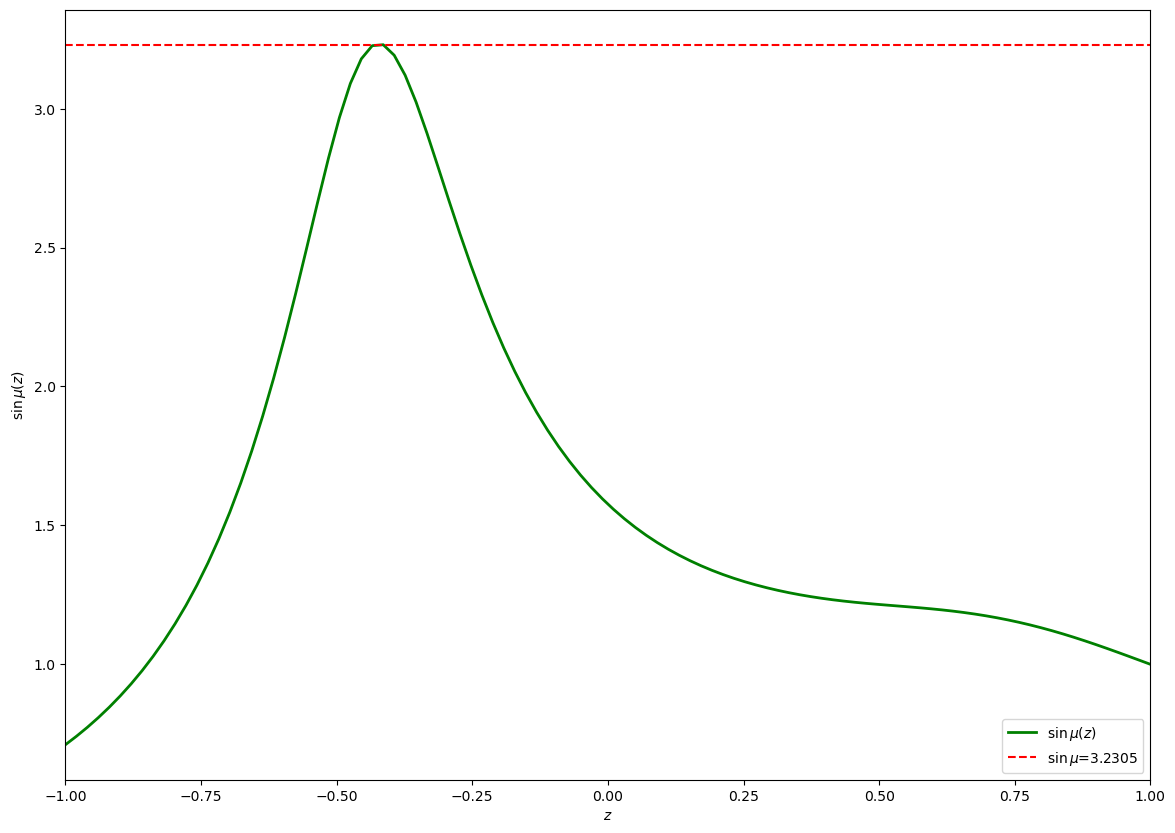

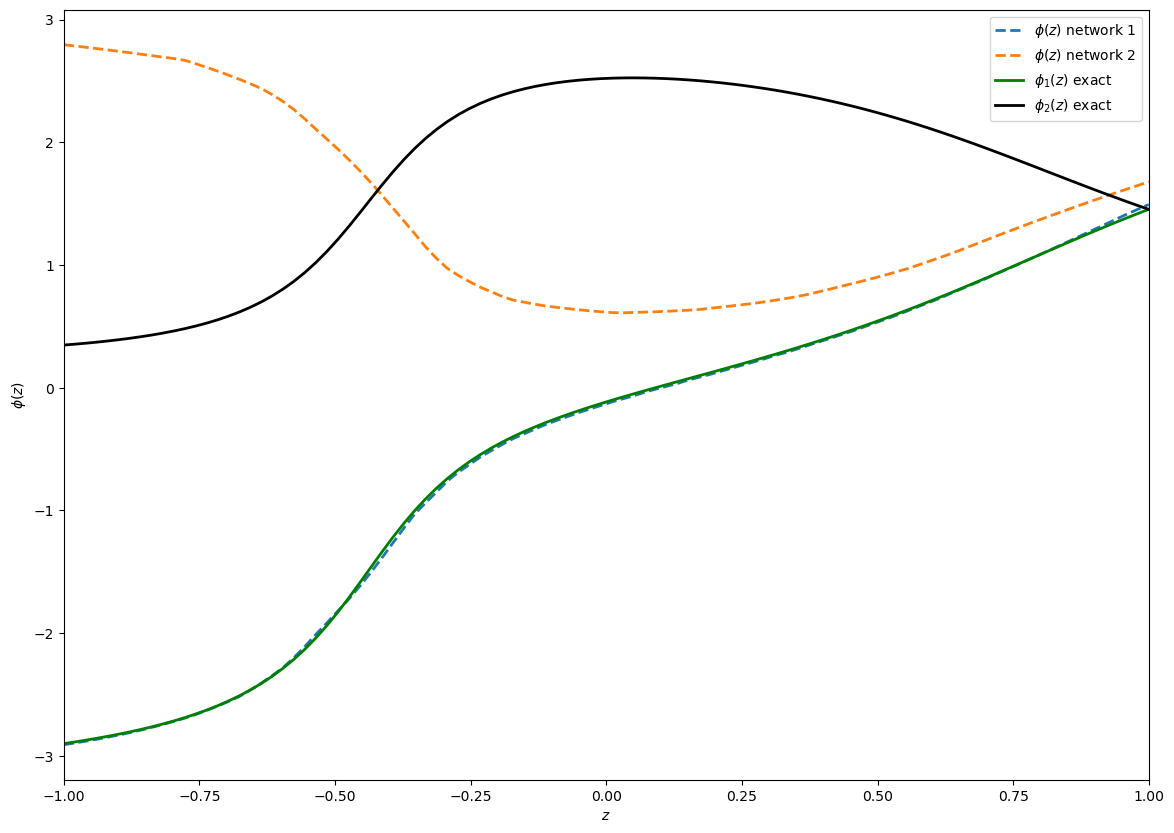

In [194]:
phievals = []
eval_pt_loss_ses = []
eval_pt_loss_no_ses= []

for i in range(params['num_nets']):
    
    if params['num_nets'] > 1: 
        netsolver_sharp.phi_net = netsolver_sharp.multi_nets[i]
    zpointseval, phieval, _, eval_pt_loss_s, eval_pt_loss_no_s = eval_run(netsolver_sharp, params, device)
    phievals.append(phieval)
    eval_pt_loss_ses.append(eval_pt_loss_s)
    eval_pt_loss_no_ses.append(eval_pt_loss_no_s)

plot_phases(zpointseval, phievals)
plot_point_loss_crichton(zpointseval, eval_pt_loss_ses, eval_pt_loss_no_ses)

integralz = sin_mu_integral(params, device, netsolver_sharp, zpointseval)
plot_sin_mu(zpointseval, integralz)

plot_summary_crichton(zpointseval, phievals)

Pictures for the sharp repulsive loss. We take the trivial ambiguity of the solution found by the network to map in to the theoretical prediction

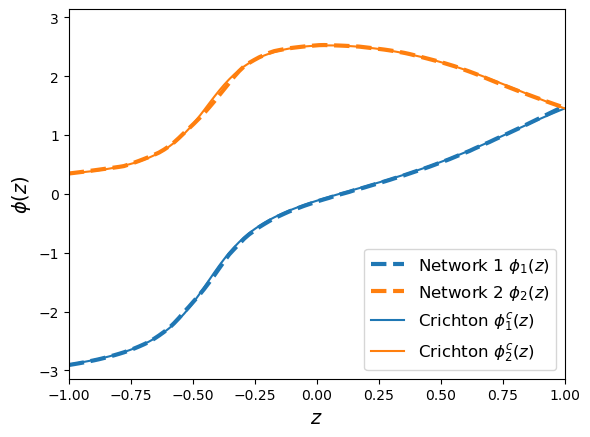

In [195]:
sol1, sol2 = crichton_solutions(zpointseval)

fig = plt.figure()
plt.plot(zpointseval.cpu().numpy(), phievals[0],  '--',lw=3)
plt.plot(zpointseval.cpu().numpy(), math.pi - phievals[1], '--', lw=3)
plt.plot(zpointseval.cpu().numpy(), sol1, 'tab:blue')
plt.plot(zpointseval.cpu().numpy(), sol2, 'tab:orange')
plt.xlabel('$z$', fontsize=14)
plt.xlim([-1,1])
plt.ylabel('$\phi(z)$', fontsize=14)
plt.ylim([-math.pi, math.pi])
plt.legend(['Network 1 $\phi_1(z)$', 'Network 2 $\phi_2(z)$', 'Crichton $\phi_1^c(z)$', 'Crichton $\phi_2^c(z)$'], loc='lower right', fontsize=12)
plt.show()

##### Enabling the decaying repulsive loss

In [189]:
params = {'batch_size': 64,
         'epochs_num': 10000,
         'learning_rate': 0.003,
         'lr_scheduler': True,
         'repulsive_epochs': [0, 1000],
         'repulsive_type' : 'decay',
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'layer_list' : [64,64, 64, 64],
         'final_layer': 'Tanh',
         'func_class': None,
         'loss': 'MSE',
         'scaled_loss': False,
         'scan_param': None,
         'num_nets': 2,
         'p_value': 2,
         'lambda_repulsive': 50.0}

In [190]:
crichtonnet = ModuleNetCrichton()
netsolver_decay = train_run(params, device, module_net=crichtonnet, seed_num=42, optim_name='Adam', log_loss=True)

  0%|          | 0/10000 [00:00<?, ?epoch/s]

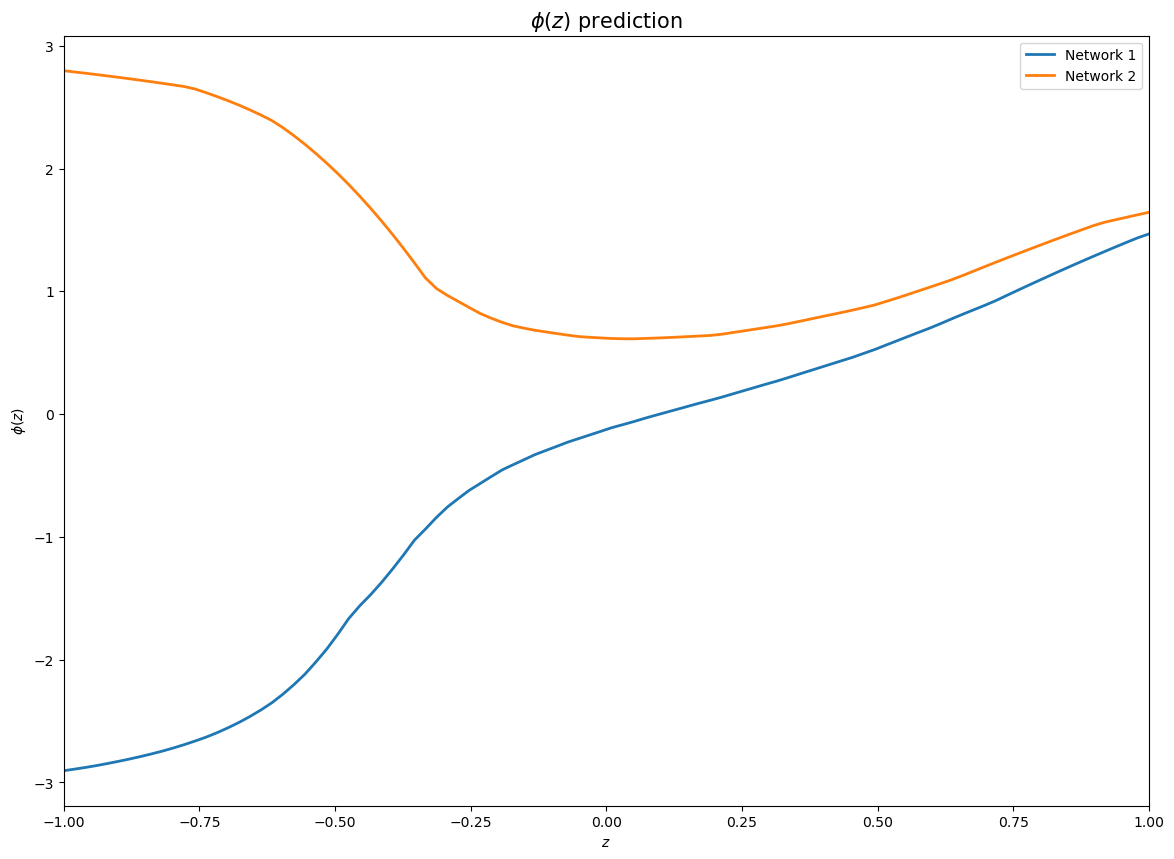

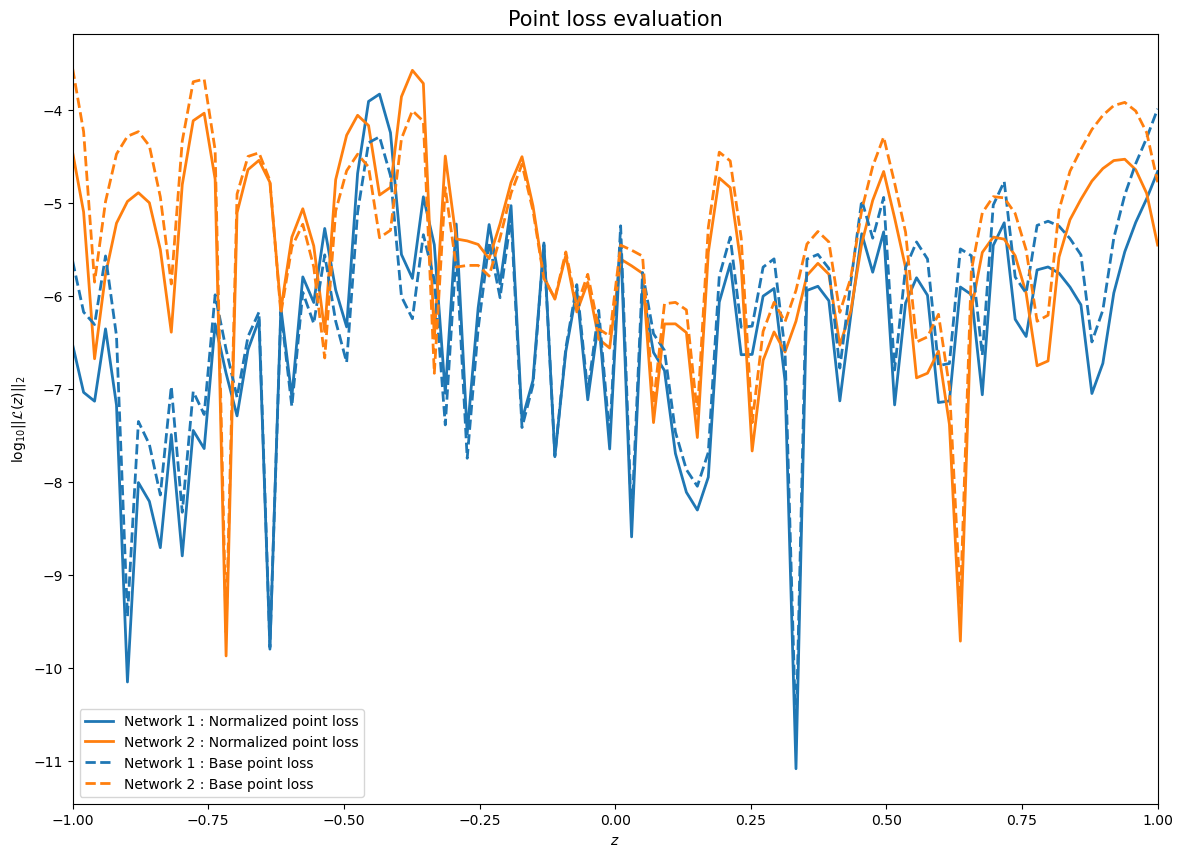

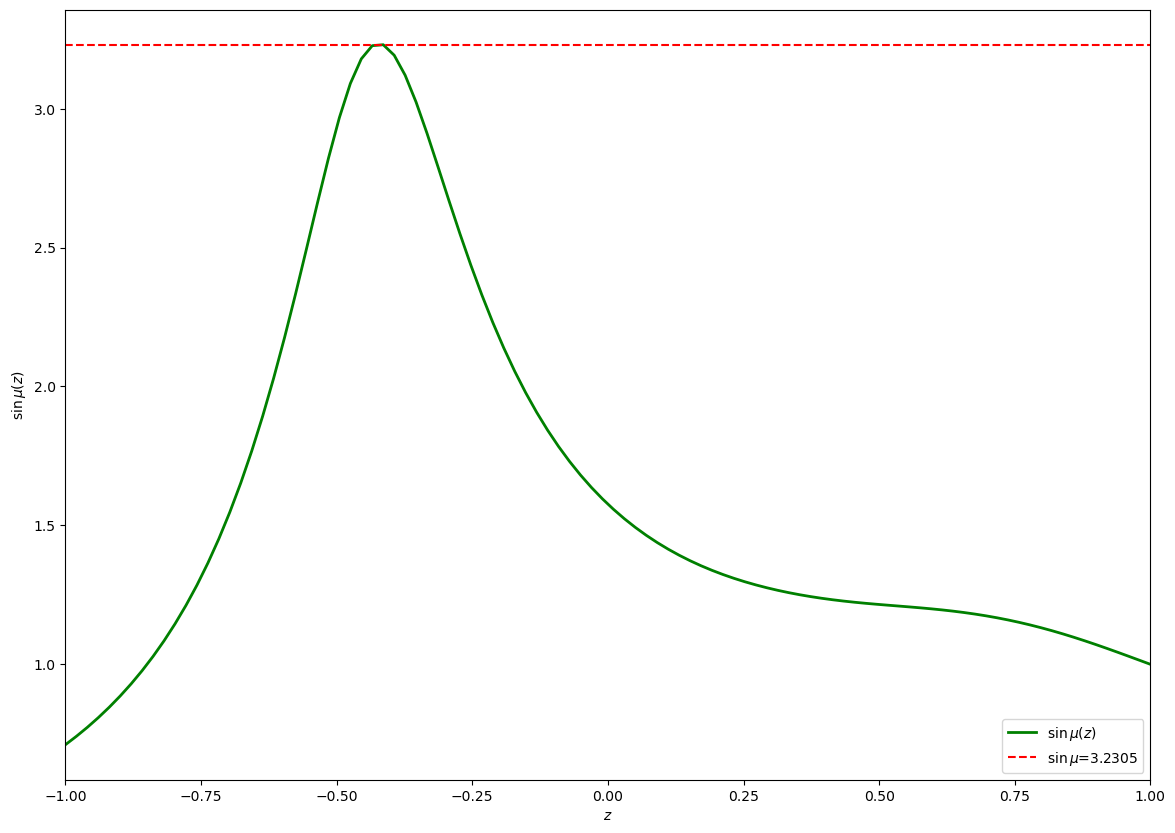

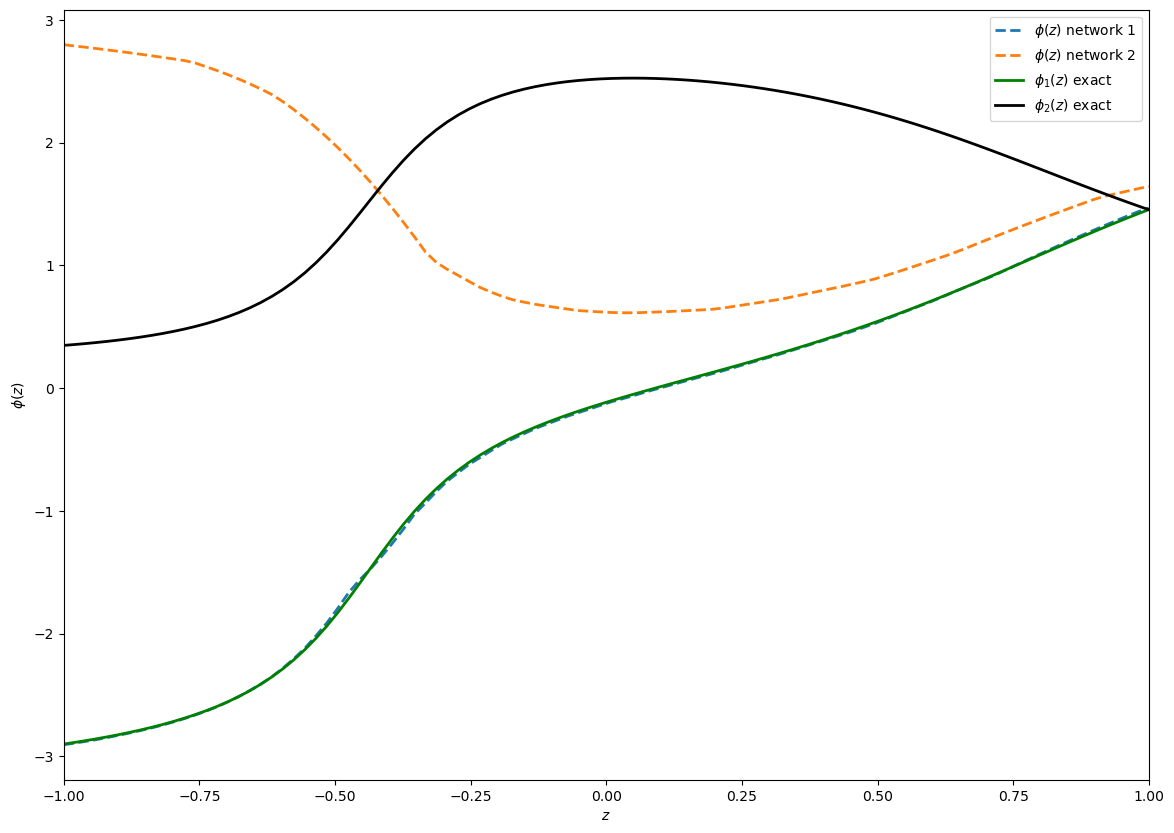

In [198]:
phievals2 = []
eval_pt_loss_ses2 = []
eval_pt_loss_no_ses2= []

for i in range(params['num_nets']):
    
    if params['num_nets'] > 1: 
        netsolver_decay.phi_net = netsolver_decay.multi_nets[i]
    zpointseval, phieval, _, eval_pt_loss_s, eval_pt_loss_no_s = eval_run(netsolver_decay, params, device)
    phievals2.append(phieval)
    eval_pt_loss_ses2.append(eval_pt_loss_s)
    eval_pt_loss_no_ses2.append(eval_pt_loss_no_s)

plot_phases(zpointseval, phievals2)
plot_point_loss_crichton(zpointseval, eval_pt_loss_ses2, eval_pt_loss_no_ses2)

integralz2 = sin_mu_integral(params, device, netsolver_decay, zpointseval)
plot_sin_mu(zpointseval, integralz2)

plot_summary_crichton(zpointseval, phievals2)

Picture for the phases from the decaying loss

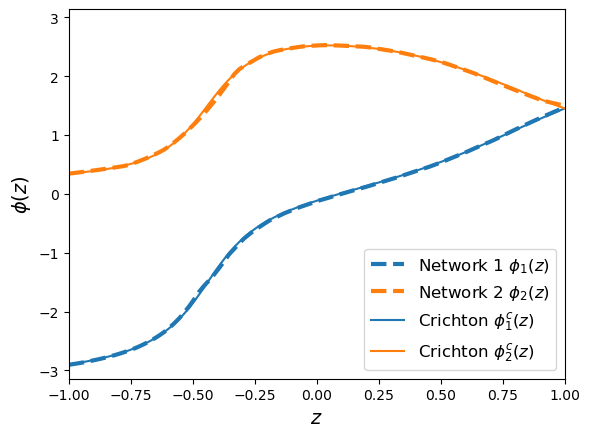

In [199]:
sol1, sol2 = crichton_solutions(zpointseval)

fig = plt.figure()
plt.plot(zpointseval.cpu().numpy(), phievals2[0],  '--',lw=3)
plt.plot(zpointseval.cpu().numpy(), math.pi-phievals2[1], '--', lw=3)
plt.plot(zpointseval.cpu().numpy(), sol1, 'tab:blue')
plt.plot(zpointseval.cpu().numpy(), sol2, 'tab:orange')
plt.xlabel('$z$', fontsize=14)
plt.xlim([-1,1])
plt.ylabel('$\phi(z)$', fontsize=14)
plt.ylim([-math.pi, math.pi])
plt.legend(['Network 1 $\phi_1(z)$', 'Network 2 $\phi_2(z)$', 'Crichton $\phi_1^c(z)$', 'Crichton $\phi_2^c(z)$'], loc='lower right', fontsize=12)
plt.show()

##### Comparing the two loss functions

Look at the actual loss function evolution and compare them. Get them from the trained solvers

In [219]:
import pandas as pd

loss_sharp = [loss.detach().cpu().numpy() for loss in netsolver_sharp.log_loss_values]
loss_decay = [loss.detach().cpu().numpy() for loss in netsolver_decay.log_loss_values]

frame_sharp = pd.DataFrame(loss_sharp, columns=["Loss"])
frame_decay = pd.DataFrame(loss_decay, columns=["Loss"])

frame_sharp['Loss_Roll'] = frame_sharp['Loss'].rolling(10).mean()
frame_decay['Loss_Roll'] = frame_decay['Loss'].rolling(10).mean()

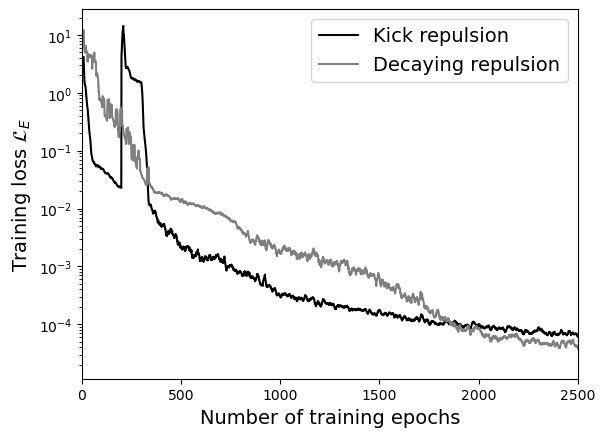

In [221]:
fig = plt.figure()

plt.plot(frame_sharp['Loss_Roll'], 'k')
plt.plot(frame_decay['Loss_Roll'], 'tab:grey')
plt.yscale("log")
plt.xlim([0, 2500])
plt.xlabel('Number of training epochs', fontsize=14)
plt.ylabel('Training loss $\mathcal{L}_E$', fontsize=14)
plt.legend(['Kick repulsion','Decaying repulsion'], fontsize=14)
plt.show()